## Block A (KI-Folgenabschätzung für ein Hausratprodukt mit soziodemographischen Merkmalen) [105 Punkte]

Vanessa Dietze, 08.10.2024

Benötigte Materialien: daten_teil_a.csv  
Bei einem Komposit-Versicherer ist im Bereich Hausrat ein innovatives Produkt im Einsatz: Im Gegensatz zu Standard-Tarifen kommen hier u.a. Merkmale zum Einsatz, die im weiteren Sinne als soziodemographisch betrachtet werden können. Vertrieb und Aktuariat sind mit dem Produkt zufrieden, doch wirft der Artificial Intelligence Act (AI-Act) seine Schatten voraus: Nicht nur ist unklar, wie dieser in der Rechtssystematik zum VAG stehen wird, konkret ist auch fraglich, ob die Verwendung von Merkmalen, die im Sinne des Allgemeinen Gleichbehandlungsgesetzes (AGG) als diskriminierend designiert sind, weiterhin bei signifikantem Schadeneinfluss zur Verwendung freigegeben sind.
Zu diesem Zweck soll eine Workforce gestartet werden, die eine KI-Folgenabschätzung für dieses Produkt vornehmen soll. Als Teil dieser Workforce sind sowohl Data-Analytics-Themen zu behandeln, als auch regulatorische (AI Act) als auch datenschutzrechtliche (DSGVO) Aspekte zu betrachten.

In [1]:
# Importieren aller relevanten Pakete und setzen globaler Variablen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import ElasticNetCV, ElasticNet
import warnings
warnings.filterwarnings('ignore')
seed = 23
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
import matplotlib.patches as patches
import scipy.stats as stats
from scipy.stats import chi2_contingency
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from fairlearn.preprocessing import CorrelationRemover
from tensorflow.keras import backend as K

2025-05-25 18:15:55.095598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Definitionen und Funktionen

# Die Funktion `plot_num` erzeugt für jedes numerische Merkmal eines Dataframes einen Kerndichteschätzer-Plot
def plot_num(data, n_cols,n_rows, title, odd):
 cols = data.select_dtypes(exclude='category').columns.tolist()
 fg,ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_rows, 3*n_cols), squeeze=False)
 plt.suptitle(title, fontsize=18, y=0.95)
 j=0;
 i=0;
 for col in cols:
     sns.histplot(x= col, data=dfdata_raw, ax=ax[i,j], kde=True, bins=20)
     i += 1
     if(i>=n_rows):
         i = 0
         j += 1
 if (odd == True): 
     fg.delaxes(ax[n_rows-1][n_cols-1])


# Plotten der Vorhersagen auf Einzelvertragsebene zwischen Basisprämie und fairer Prämie
def comparison_base_fair(y_pred, y_pred_fair, age_values):
    # Plotten Basisprämie vs faire Prämie auf Einzelvertragsebene und nach Alter
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

    # Plotten der Basisprämie und der fairen Prämie auf Einzelvertragsebene auf Einzelvertragsebene
    axs[0].scatter(range(len(y_pred)), y_pred, label='Basisprämie', alpha=0.6)
    axs[0].scatter(range(len(y_pred_fair)), y_pred_fair, label='faire Prämie', alpha=0.6)
    axs[0].set_xlabel('Vertragsindex')
    axs[0].set_ylabel('Prämienhöhe')
    axs[0].set_title('Vergleich der Basisprämie und der fairen Prämie (Einzelvertragsebene)')
    axs[0].legend()
    
    # Plotten der Basisprämie und der fairen Prämie auf Einzelvertragsebene nach Alter
    axs[1].scatter(age_values, y_pred, label='Basisprämie', alpha=0.6)
    axs[1].scatter(age_values, y_pred_fair, label='faire Prämie', alpha=0.6)
    axs[1].set_xlabel('Alter')
    axs[1].set_ylabel('Prämienhöhe')
    axs[1].set_title('Vergleich der Basisprämie und der fairen Prämie (nach Alter)')
    axs[1].legend()
    
    # Plotten
    plt.show()
    
    # Berechnen der durchschnittlichen Prämien
    average_base_premium = y_pred.mean()
    average_fair_premium = y_pred_fair.mean()
    
    # Vergleich der durchschnittlichen Prämien
    print(f'Durchschnittliche Basisprämie: {average_base_premium}')
    print(f'Durchschnittliche faire Prämie: {average_fair_premium}')

# Plotten der Differenzen pro Alter
def scatterplot_differences(y_pred, y_pred_fair, age_values):
    plt.figure(figsize=(10, 6))
    plt.scatter(age_values, y_pred_fair-y_pred , alpha=0.6)
    plt.xlabel('Alter')
    plt.ylabel('Differenz der Prämien')
    plt.title('Differenz zwischen der Basisprämie und der fairen Prämie pro Alter')
    plt.legend()
    plt.show()

# Plotten der Basis- vs. fairen Prämie auf aggregierter Ebene
def aggregated_plots(y_pred, y_pred_fair):
    # Vergleich der Basisprämie und der fairen Prämie auf aggregierter Ebene
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogramm für Basisprämie vs faire Prämie
    axs[0].hist(y_pred, bins=30, alpha=0.5, label='Basisprämie')
    axs[0].hist(y_pred_fair, bins=30, alpha=0.5, label='faire Prämie')
    axs[0].set_xlabel('Prämienhöhe')
    axs[0].set_ylabel('Häufigkeit')
    axs[0].set_title('Verteilung der Basisprämie vs faire Prämie')
    axs[0].legend(loc='upper right')
    
    # Boxplot für Basisprämie vs faire Prämie
    axs[1].boxplot([y_pred, y_pred_fair], labels=['Basisprämie', 'faire Prämie'])
    axs[1].set_ylabel('Prämienhöhe')
    axs[1].set_title('Boxplot der Basisprämie und der fairen Prämie')
    
    # Plotten
    plt.show()

### Aufgabe 1: [Datenanalyse] [10 Punkte]
Verschaffen Sie sich einen Überblick über Bestand und Tarifgestaltung. Geben Sie eine deskriptive Übersicht über die vorhandenen Daten und formulieren Sie Hypothesen dazu, welche Problemfelder zu betrachten sein werden.

In [3]:
# Einlesen der csv, Trennzeichen ';', Dezimal ','
dfdata_raw = pd.read_csv(r"/Users/vanessadietze/Documents/Dokumente/Vanessa/DAV Ausbildung/ADS/ADS4/Abgabe/PRF3116_Aufgaben_D/daten_teil_a.csv", 
                         delimiter=",", decimal=".", index_col = 0)

In [4]:
# Zeilen- und Spaltenanzahl ausgeben
amount_rows, amount_cols = dfdata_raw.shape
print(f'Zeilenanzahl: {amount_rows}, Spaltenanzahl: {amount_cols}')

# Datentypen von allen Merkmalen
print(f'Datentypen der Merkmale:\n{dfdata_raw.dtypes}')

# Ausgabe von sieben zufälligen Zeilen
dfdata_raw.head()

Zeilenanzahl: 25000, Spaltenanzahl: 8
Datentypen der Merkmale:
Gender               int64
Age                float64
SquareM            float64
HouseholdIncome    float64
InventoryValue     float64
CityType             int64
freq               float64
Response           float64
dtype: object


Gender   Age    SquareM  HouseholdIncome  InventoryValue  CityType  \
0       0  48.0  49.617370      3537.718263    58643.676273         1   
1       1  62.0  77.658077      4919.930510    71178.094870         0   
2       0  50.0  76.729102      3211.411617    60836.563534         2   
3       1  52.0  78.677732      5100.980057    65429.750542         1   
4       0  32.0  65.935428      1503.428350    44714.260511         2   

       freq    Response  
0  0.046033   46.033082  
1  0.112187  112.186845  
2  0.071084   71.084081  
3  0.074637   74.637405  
4  0.072209   72.209132

<ins>Kommentar</ins>: Es gibt 25.000 Zeilen im Datensatz und 8 Merkmale. Alle Merkmale sind numerisch. 

In [5]:
print(dfdata_raw.describe())

             Gender           Age       SquareM  HouseholdIncome  \
count  25000.000000  25000.000000  25000.000000     25000.000000   
mean       0.294480     48.308560     67.297495      2809.448877   
std        0.455818     11.481755     24.446981      1020.819194   
min        0.000000     18.000000     20.000000         0.000000   
25%        0.000000     40.000000     50.272735      2094.143615   
50%        0.000000     48.000000     66.955000      2810.773562   
75%        1.000000     56.000000     83.892950      3487.983953   
max        1.000000     88.000000    162.744554      7025.897705   

       InventoryValue     CityType          freq      Response  
count    25000.000000  25000.00000  25000.000000  25000.000000  
mean     60507.832168      1.20092      0.079821     81.803514  
std      12146.142550      0.81271      0.039671     37.368187  
min      19286.747349      0.00000      0.017661     45.000000  
25%      52172.510391      1.00000      0.052946     52.945724

<ins>Kommentar</ins>: Jedes Merkmal hat 25.000 Einträge, was darauf schließen lässt, dass es keine Null-Values im Datensatz gibt. Gender hat die Einträge 0 und 1 und das Alter reicht von 18 bis 88 Jahren. Die Merkmale Quadratmeter, Haushaltseinkommen und Inventarwert variieren stark. Die Untergrenze der Quadratmeter Fläche beginnt bei 20. City Type hat die Ausprägungen 0,1 und 2. Frequenz und Response haben für die Quantile sehr ähnliche Einträge wobei die Response einen Faktor von 1000 mal so hoch liegt.

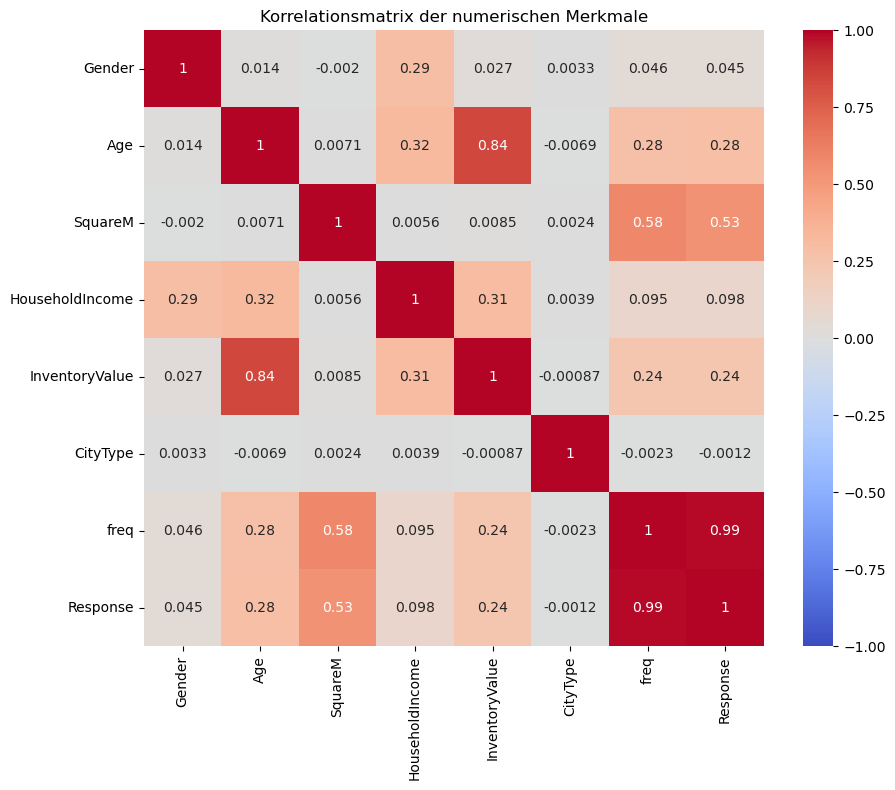

In [6]:
# Berechnung der Korrelationsmatrix
corr_matrix = dfdata_raw.select_dtypes(include ='number').corr()

# Heatmap der Korrelationsmatrix um Abhängigkeiten zu visualisiern
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korrelationsmatrix der numerischen Merkmale')
plt.show()

<ins>Kommentar</ins>: Die meisten Korrelationen der Merkmale sind eher gering. Was besonders heraussticht, ist die extrem hohe Korrelation zwischen Frequenz und Response. Diese liegt bei 0.99. Dies bedeutet, dass die beiden Variablen fast perfekt korreliert sind.  
Eine etwas niedrigere, aber weiterhin hohe, Korrelation besitzen auch die Merkmale Alter und Inventarswert. Diese haben eine positive Korrelation von 0.85.  
Auch die Korrelation von Response und Frequenz mit dem Merkmal Quadratmeter ist mit 0.53 bzw. 0.58 recht hoch.

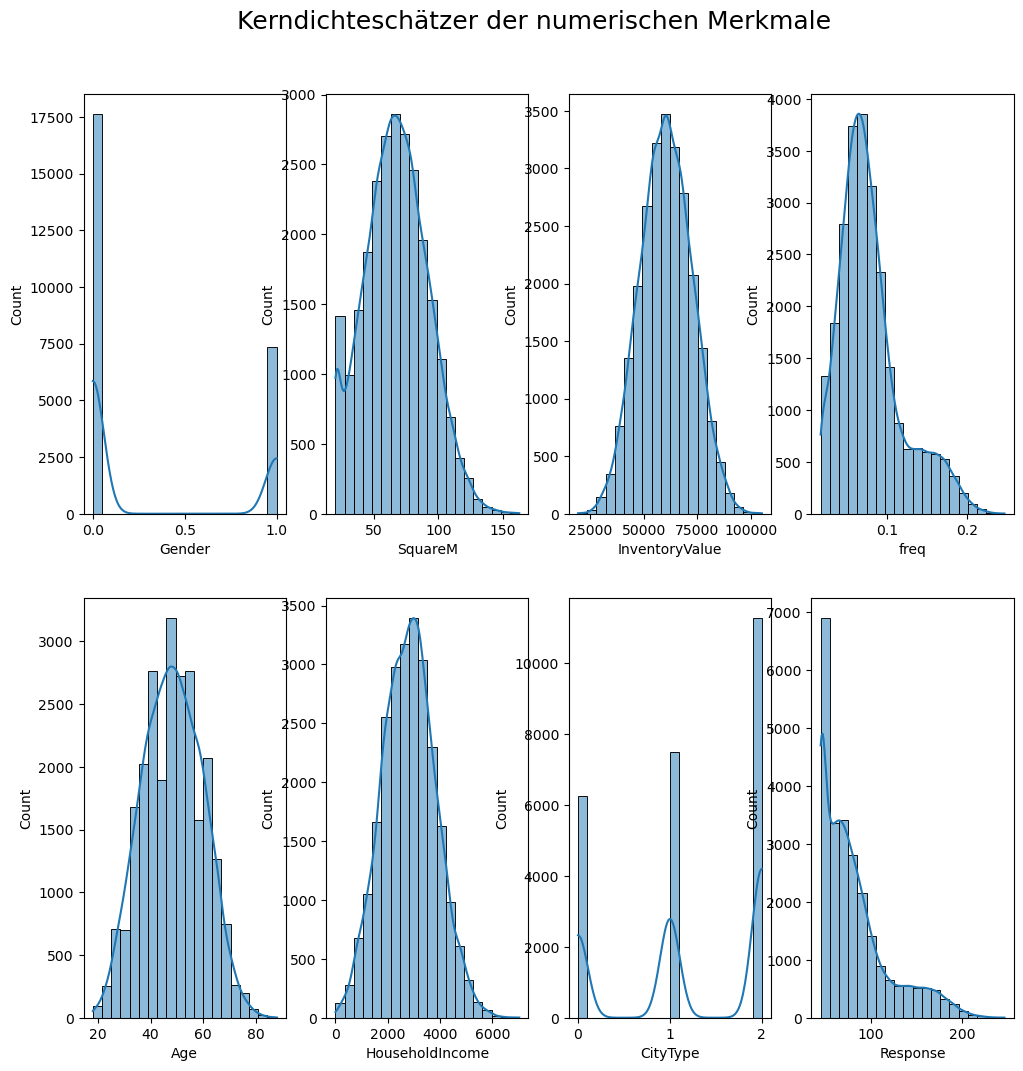

In [7]:
# Visualisierung der Dichteschätzung der numerischen Merkmale
plot_num(dfdata_raw, 4, 2, 'Kerndichteschätzer der numerischen Merkmale', False)

<ins>Kommentar</ins>: Die Merkmale Quadratmeter, Inventarwert, Alter und Haushaltseinkommen sind alle recht normalverteilt. Bei dem Merkmal Alter erkennt man eine deutlich höhere Häufigkeit bei der Ausprägung 0 (ca. 17500) im Vergleich zur Ausprägung 1 (ca. 7500). City Type hat eine aufsteigende Anzahl der Ausprägungen. Response hat hohe Ausprägungen auf der linken Seite und flacht in Richtung höheren Response Werten ab. Die Frequenz hat eine ähnliche Form wie der Response Graph, allerdings wird hier zuerst noch ein Anstieg auf der linken Seite verzeichnet.


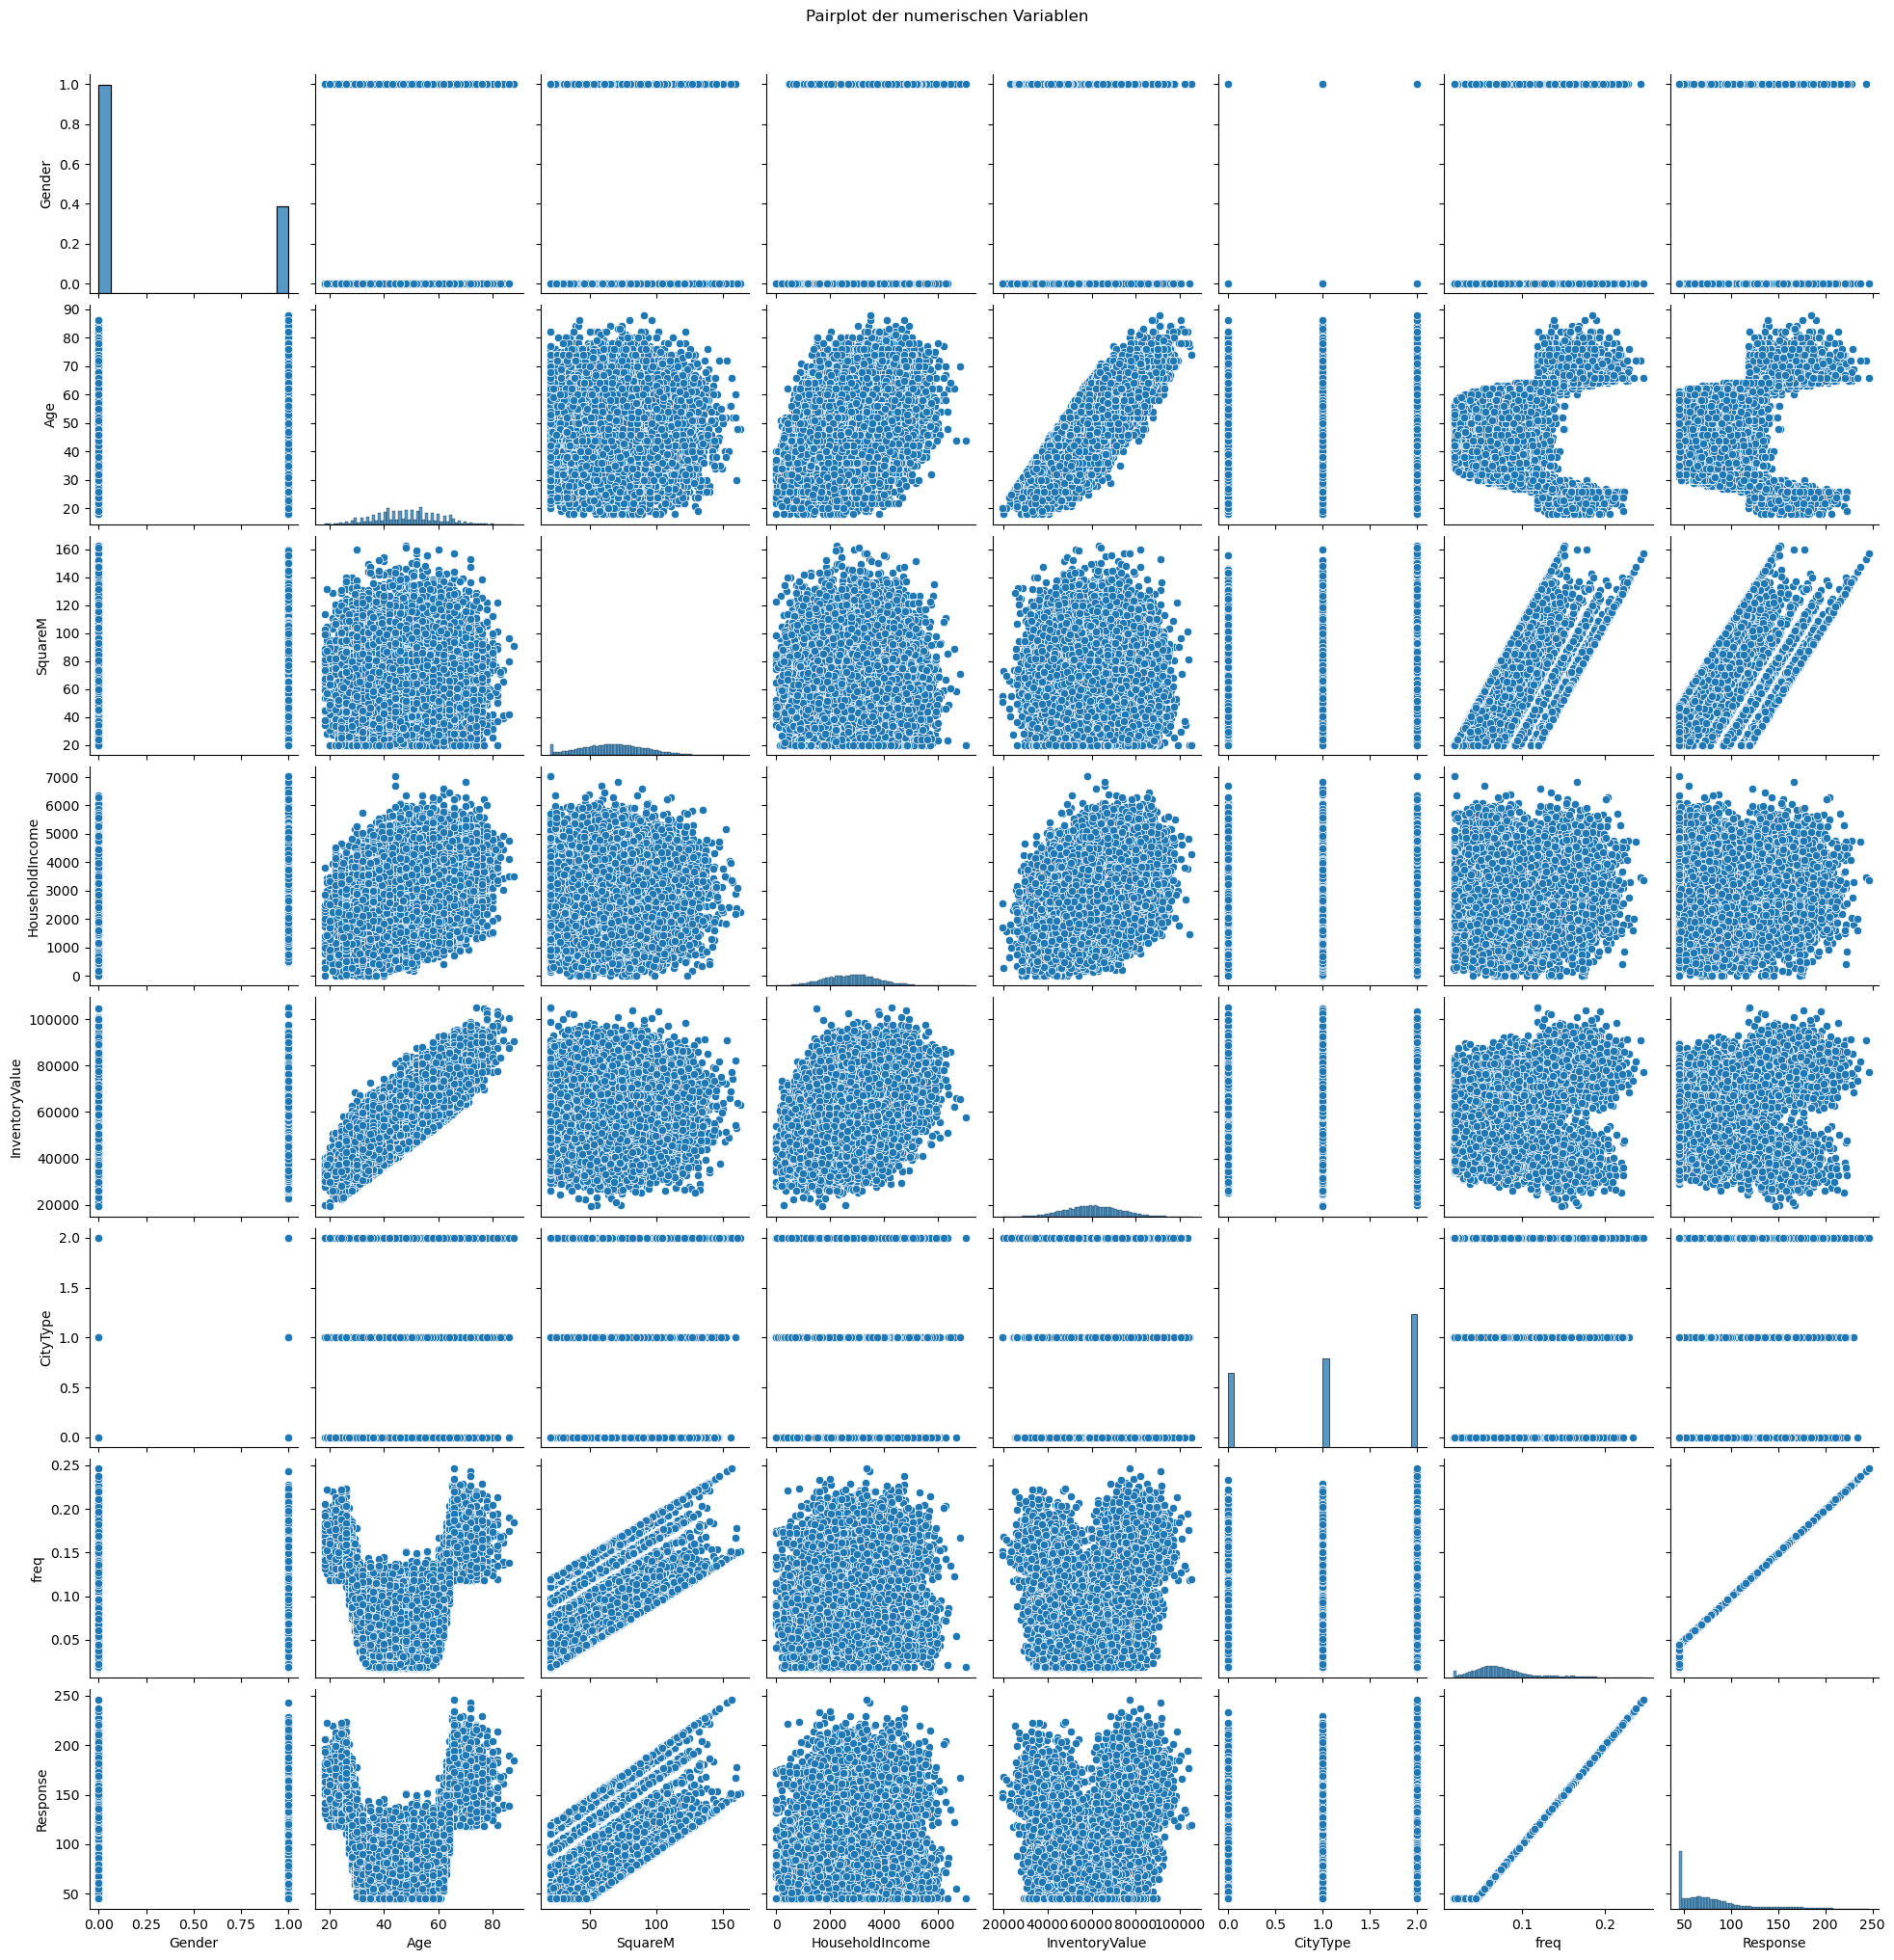

In [8]:
# Pairplot der Merkmale
sns.pairplot(dfdata_raw)
plt.suptitle('Pairplot der numerischen Variablen', y=1.02)
plt.show()

<ins>Kommentar</ins>: Man erkennt hier sehr gut die lineare Abhängigkeit von Frequenz und Response. Bei City Type und Geschlecht erkennt man klar die jeweiligen Ausprägungen der Merkmale. Inventarwert und Alter, sowie Quadratmeter und Response sind linear abhängig. Man erkennt eine leichte quadratische Abhängigkeit von Inventory Value zu Response und von Alter zu Response.

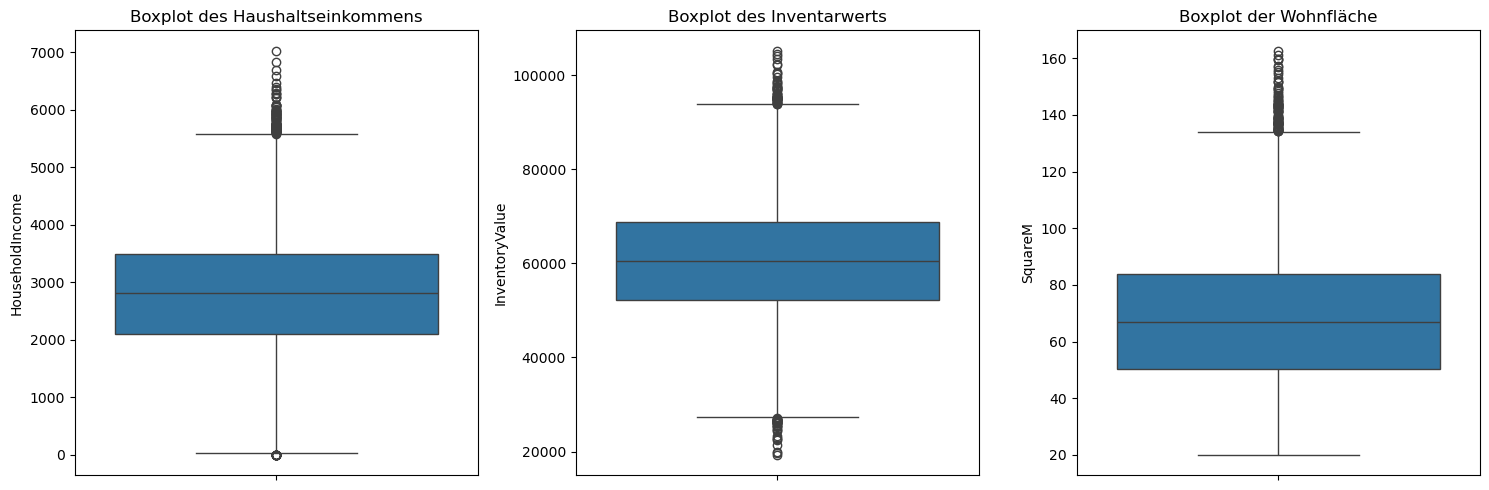

In [9]:
# Boxplots
plt.figure(figsize=(15, 5))

# Haushaltseinkommen
plt.subplot(1, 3, 1)
sns.boxplot(y='HouseholdIncome', data=dfdata_raw)
plt.title('Boxplot des Haushaltseinkommens')

# Inventarwert
plt.subplot(1, 3, 2)
sns.boxplot(y='InventoryValue', data=dfdata_raw)
plt.title('Boxplot des Inventarwerts')

# Quadratmeter der Wohnfläche
plt.subplot(1, 3, 3)
sns.boxplot(y='SquareM', data=dfdata_raw)
plt.title('Boxplot der Wohnfläche')

plt.tight_layout()
plt.show()

<ins>Kommentar</ins>: Man erkennt bei allen 3 Merkmalen einige Ausreißer am oberen Ende des Plots. Bei dem Merkmal Inventarwert gibt es auch Ausreißer auf der anderen Seite. 

In [10]:
# Chi-Quadrat-Test zwischen 'Gender' und 'CityType'
cross_table = pd.crosstab(dfdata_raw['Gender'], dfdata_raw['CityType'])

# Chi-Quadrat-Test durchführen
chi2, p, _, _ = chi2_contingency(cross_table)

# Ausgabe der Werte
print(f"Chi-Quadrat-Wert: {chi2}")
print(f"p-Wert: {p}")


Chi-Quadrat-Wert: 0.5067801924867203
p-Wert: 0.7761650436917977


<ins>Kommentar</ins>: Der Chi-Quadrat-Wert gibt einen Hinweis darauf, wie stark beobachtete Häufigkeiten von erwarteteten Häufigkeiten abweichen. Dieser Wert ist hier relativ niedrig, sodass es keine starken Abweichungen gibt und die beiden Merkmale City Type und Geschlecht unabhängig sind.  
Der p-Wert gibt die Wahrscheinlichkeit an, ob die Unterschiede in der Beobachtung zufällig sind. Ein hoher p-Wert gibt an, dass die Merkmale keine signifikanten Assoziationen haben. Somit sind die Merkmale Geschlecht und City Type nicht signifikant voneinander abhängig.

<ins>Kommentar</ins>: Problemfelder und mögliche Hypothesen:  
Ein mögliches Problemfeld ist das Merkmal Geschlecht. Dieses darf seit 2012 nicht mehr für die Tarifierung verwendet werden, da es als diskriminierend betrachtet wird. 
Hypothese: Geschlecht muss aus gesetzlichen Gründen aus dem Modell genommen werden und es dürfen nur Unisex Tarife verwendet werden.  

Ein weiteres Problemfeld könnte das Alter sein. Durch fortschreitende Entwicklungen im Leben und höheren Einkommen im Verlauf, könnte das Alter einen großen Einfluss auf das Haushaltseinkommen und den Inventarwert haben.
Hypothese: Ältere Menschen haben höhere Einkommen und dementsprechend einen höheren Inventarwert.  

Frequenz ist ein Merkmal, welches auch zu Problemen führen kann. Da Response und Frequenz sehr stark voneinander abhängig sind und Frequenz schon fast die Zielvariable vorhersagen kann, ist es notwendig dieses auszuschließen. 
Hypothese: Um keine komplette Abhängigkeit im Modell zu halten, ist es notwendig Frequenz auszuschließen.  

Das Merkmal Stadttyp könnte einen großen Einfluss auf bspw. das Haushaltseinkommen und den Lebensstandard haben. 
Hypothese: In bestimmten Stadttypen könnten tendenziell Menschen mit höherem oder niedrigerem Haushaltseinkommen wohnen. 

### Aufgabe 2: [Tarifmodell] [10 Punkte]
Betrachten Sie die beiden Merkmale Geschlecht und Alter. Sind diese siginifikante Prädiktoren im Tarif?

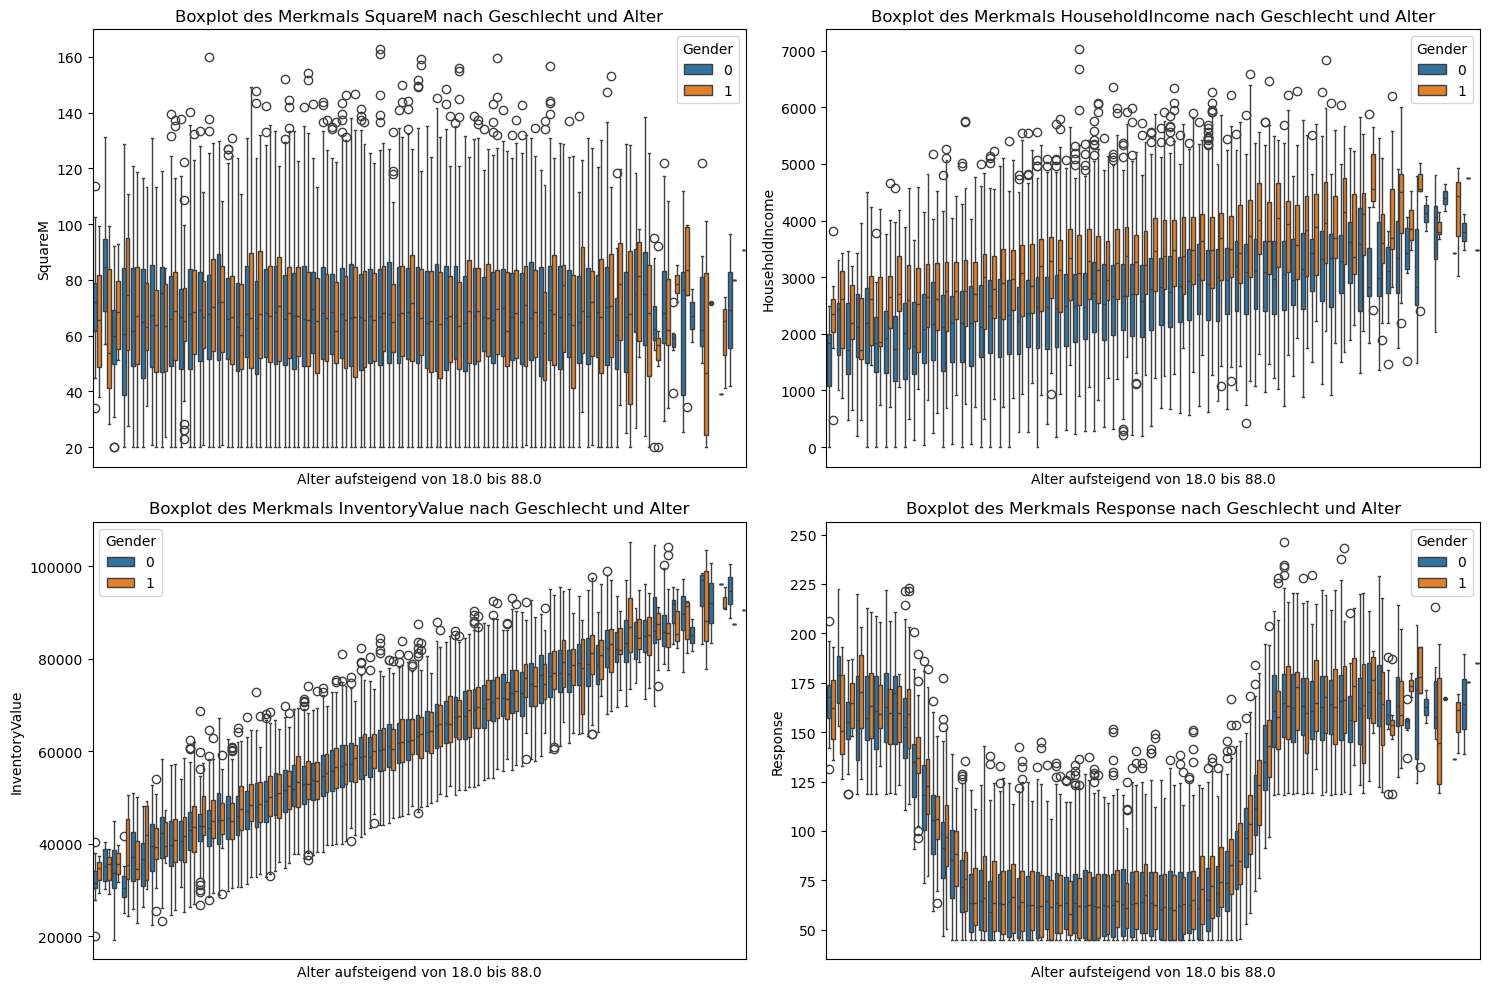

In [11]:
# Merkmale, die wir auf Abhängigkeiten zu Geschlecht und Alter untersuchen wollen
features = ['SquareM', 'HouseholdIncome', 'InventoryValue', 'Response']

# Plotten der Abhängigkeiten für Alter und Geschlecht
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Age', y=feature, hue='Gender', data=dfdata_raw)
    plt.title(f'Boxplot des Merkmals {feature} nach Geschlecht und Alter') 
    plt.xticks([]) 
    plt.xlabel('Alter aufsteigend von ' + str(min(dfdata_raw['Age'])) + ' bis ' +  str(max(dfdata_raw['Age'])))

# Ausgabe des Plots
plt.tight_layout()
plt.show()

<ins>Kommentar</ins>: Grundsätzlich erkennt man keine allzugroßen Unterschiede zwischen Männern und Frauen. Lediglich beim Haushaltseinkommen liegt das Einkommen der Ausprägung 1 deutlich höher als das Einkommen der Ausprägung 0. Mit steigendem Alter erkennt man steigendes Haushaltseinkommen und steigenden Inventarwert. Die Response verhält sich quadratisch zum Alter. Die Wohnfläche bleibt in etwa konstant. Man könnte meinen, dass Alter und Geschlecht eventuell signifikante Merkmale sind. Dies wird im Verlauf weiter untersucht.

Trainieren Sie ein Tarifmodell, das den Schadenbedarf Response fittet und bewerten Sie den Impact, wenn die Merkmale entfernt werden müssten.

In [12]:
# Skalieren der Daten mit dem StandardScaler
scaler = StandardScaler()

# Entfernen der Zielvariable
features = dfdata_raw.drop(columns='Response')

#Setzen der Zielvariable
response = dfdata_raw['Response']

# Skalierung der erklärenden Merkmale und Setzen der Spaltennamen
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Zusammenfügen der Daten
dfdata_scaled = pd.concat([features_scaled_df, response], axis=1)

#### Erstes lineares Modell mit allen Merkmalen

In [13]:
# Setzen der Ziel- und erklärenden Variable
y = dfdata_scaled['Response']
X = dfdata_scaled.drop(['Response'], axis = 1)

# Splitten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Intercept anhängen für das lineare Modell
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)

# Fitten des linearen Modells
linear_model = sm.OLS(y_train, X_train_constant).fit()

# Zusammenfassung der Statistiken des ersten Modells
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.900e+05
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:                -58660.
No. Observations:               20000   AIC:                         1.173e+05
Df Residuals:                   19992   BIC:                         1.174e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.8112      0.032   25

<ins>Kommentar</ins>: R^2 liegt bei 0.985. Dies ist sehr nahe an 1, was auf sehr gute bis fast perfekte Vorhersagen hindeutet. An den Koeffizienten erkennt man, dass lediglich Frequenz wirklich hoch ins Gewicht fällt. Da wir bereits festgestellt haben, dass Frequenz und Response sehr voneinander abhängen, nehmen wir Frequenz in Zukunft aus den Modellen raus, da wir ansonsten kein wirkliches Modell benötigen würden. 

#### Zweites lineares Modell ohne Frequenz

In [14]:
# lineares Modell ohne Frequenz
# Entfernen des Merkmals Frequenz
X_train_wofreq = X_train.drop(['freq'], axis=1)
X_test_wofreq = X_test.drop(['freq'], axis = 1)
X1_train_constant = X_train_constant.drop(['freq'], axis=1)
X1_test_constant = X_test_constant.drop(['freq'], axis = 1)

# Fitten eines neuen linearen Modells
linear_model2 = sm.OLS(y_train, X1_train_constant).fit()

# Zusammenfassung der Statistiken des zweiten Modells
print(linear_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     1914.
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:                -96248.
No. Observations:               20000   AIC:                         1.925e+05
Df Residuals:                   19993   BIC:                         1.926e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.7568      0.211    3

<ins>Kommentar</ins>: R^2 liegt jetzt nur noch bei 0.365. Dies war zu erwarten, weil wir die abhängigste Variable entfernt haben. Nun sind die Koeffizienten für Alter, Geschlecht und Wohnfläche deutlich tragender. Im Folgenden schauen wir uns einmal die retransformierten Koeffizienten an um daraus zu schließen, ob Geschlecht und Alter wirklich signifikant sind.

#### Drittes lineares Modell ohne Frequenz, Alter und Geschlecht

In [15]:
# Rücktransformation der Koeffizienten
model_coefs = linear_model2.params

# Auslesen der Mean values und der Scale values
mean_values = scaler.mean_[:-1]
scale_values = scaler.scale_[:-1]

# Intercept wird nicht reskaliert
intercept = model_coefs[0] - np.sum(mean_values/scale_values * model_coefs[1:])

# Zurückskalieren der Featurekoeffizienten
rescaled_features = model_coefs[1:]/scale_values

# Zusammenführen von Intercept und reskalierten Koeffizienten und transformieren in einen Dataframe
rescaled_coefs = np.insert(rescaled_features, 0, intercept)
rescaled_coef_df = pd.DataFrame(rescaled_coefs, index=X1_train_constant.columns, columns=['Koeffizienten'])

# Ausgabe der reskalierten Koeffizienten
print(rescaled_coef_df)

                 Koeffizienten
const               -17.918567
Gender                3.862021
Age                   0.942315
SquareM               0.809792
HouseholdIncome      -0.000491
InventoryValue       -0.000004
CityType              0.137525


<ins>Kommentar</ins>: Da der Koeffizient fürs Alter nahe bei 1 liegt und die Alterseingaben größer gleich 18 sind, ist dieser Koeffizient sehr signifikant.  
Geschlecht hat lediglich die Ausprägungen 0 und 1, sodass dies multipliziert mit einem Koeffizienten von ca. 3.9 nicht so hoch ins Gewicht fällt, wie das Alter. Somit ist das Merkmal Alter signifikant, wohingegen Geschlecht eher insignifikant ist.  

Als nächstes schauen wir uns das Modell an, wenn wir Geschlecht und Alter entfernen und welchen Einfluss dies auf das Modell hat.

In [16]:
# Modell ohne 'Gender' und 'Age' trainieren
#Entfernen der Spalten 'Gender' und 'Age'
X2_train_constant = X1_train_constant.drop(['Gender', 'Age'], axis=1)
X2_test = X1_test_constant.drop(['Gender', 'Age'], axis = 1)

# Fitten eines neuen linearen Modells
linear_model3 = sm.OLS(y_train, X2_train_constant).fit()

# Zusammenfassung der Statistiken des dritten Modells
print(linear_model3.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     2572.
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:                -96636.
No. Observations:               20000   AIC:                         1.933e+05
Df Residuals:                   19995   BIC:                         1.933e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.7671      0.215    3

<ins>Kommentar</ins>: Das R^2 ist leicht auf 0.34 gesunken. Dies ist nicht allzu weit entfernt von dem R^2 aus dem zweiten Modell ohne Frequenz. Nun sind die Merkmale Wohnfläche und Inventarwert die Merkmale mit den höchsten Koeffizienten.   
Um einen Eindruck zu bekommen, wie signifikant die Merkmale Geschlecht und Alter sind, schauen wir uns im Folgenden die vorhergesagten Werte an.  

#### Impact auf die Modelle

In [17]:
# Vorhersagen auf allen Modellen
y_pred_full = linear_model.predict(X_test_constant)
y_pred_wofreq = linear_model2.predict(X1_test_constant)
y_pred_woall = linear_model3.predict(X2_test)

# Mean Squared Error für die drei Modelle berechnen
mse_full = mean_squared_error(y_test, y_pred_full)
mse_wofreq = mean_squared_error(y_test, y_pred_wofreq)
mse_woall = mean_squared_error(y_test, y_pred_woall)

# Koeffizienten und MSE ausgeben
print(f'Mean Squared Error: {mse_full}')
print(f'Mean Squared Error ohne Frequenz: {mse_wofreq}')
print(f'Mean Squared Error ohne Geschlecht und Alter: {mse_woall}')

# Impact der Entfernung von Geschlecht und Alter bewerten
impact = mse_full - mse_wofreq
print(f'\nImpact des Entfernens der Frequenz auf den MSE: {impact}')
impact2 = mse_wofreq - mse_woall
print(f'Impact des Entfernens von Geschlecht und Alter auf den MSE ohne Frequenz: {impact2}')
impact3 = mse_full - mse_woall
print(f'Impact des Entfernens von Geschlecht und Alter auf den MSE des gesamten Modells: {impact3}')

Mean Squared Error: 19.426611564384814
Mean Squared Error ohne Frequenz: 901.6235825296116
Mean Squared Error ohne Geschlecht und Alter: 924.4133817499375

Impact des Entfernens der Frequenz auf den MSE: -882.1969709652267
Impact des Entfernens von Geschlecht und Alter auf den MSE ohne Frequenz: -22.789799220325904
Impact des Entfernens von Geschlecht und Alter auf den MSE des gesamten Modells: -904.9867701855526


<ins>Kommentar</ins>: Der Mean Squared Error verändert sich vom gesamten Modell zu dem Modell ohne Frequenz sehr stark. Dieser springt von ca. 19 auf ca. 902. Dies war zu erwarten, da wir die größte abhängige Variable rausgestrichen haben. Der MSE zum Modell ohne Geschlecht und Alter verändert sich nicht mehr all zu viel.  
Der MSE verändert sich vom gesamten Modell auf das Modell ohne Frequenz, Geschlecht und Alter um ca. 905 nach oben (wird also deutlich schlechter). Nun könnte man meinen, dass diese Veränderung durch Geschlecht und Alter getragen wird. Deshalb schauen wir uns den Einfluss des Entfernens dieser beiden Merkmale basierend auf dem Modell ohne Frequenz an. Hier sehen wir, dass sich der MSE lediglich um ca. 23 ändert. Somit hat das Entfernen der beiden Merkmale zwar einen Einfluss, aber einen deutlich geringeren Einfluss als die Frequenz.

### Aufgabe 3: [indirekte Diskriminierung] [15 Punkte]
Beschreiben Sie die Herausforderungen von indirekter Diskriminierung über Ersatzmerkmale und identifizieren Sie, ob es Proxy-Variablen für Geschlecht und Alter im Datensatz gibt. 

<ins>Kommentar</ins>: Bei indirekter Diskriminierung geht es darum, dass zwar Hauptmerkmale aus dem Modell entfernt wurden, aber diese auch noch Einfluss/Korrelationen auf weiterhin bestehende Variablen, sogenannte Ersatzmerkmale, haben können. Diese Variablen würden dann im Modell indirekt diskriminieren. Die Herausforderung hierbei besteht darin, dass man die entsprechenden Ersatzmerkmale erkennt und die indirekte Diskriminierung entweder aus den Daten, im Modell oder in den Ergebnissen entfernt. Dies ist ein notwendiger Schritt um die Fairness des Modells zu halten. In einigen Fällen, wie beispielsweise bei dem Merkmal Geschlecht, ist es auch rechtlich erforderlich, dass das Modell nicht nach diesem Merkmal diskriminiert, auch nicht indirekt.

In unserem Modell ist eine Proxy-Variable für das Alter das Merkmal Inventarwert. 

#### L1/L2-Regularisiertes Modell: Elastic Net

Evaluieren Sie für mindestens ein L1/L2-Regularisiertes Modell den Lambda-Pfad - ist diese Betrachtung hilfreich? Betrachten Sie konkret stets die Zielvariable Response.

In [18]:
# Entfernen der Merkmale Geschlecht und Alter um direkte Diskriminierung zu meiden
X_train_wodiscr = X_train_wofreq.drop(['Gender', 'Age'], axis=1)

# Definieren der Range für die l1 Ratios und alpha Werte
l1_ratio_values = np.linspace(0, 1.0, 5)
alpha_values = np.logspace(-2, 3, 30)

# Trainieren des Elastic Nets um die beste alpha/l1-Kombination zu finden
enet = ElasticNetCV(l1_ratio=l1_ratio_values, alphas=alpha_values, cv=5, random_state=seed)
enet.fit(X_train_wodiscr, y_train)

# Ausgabe des besten alpha Wertes und des besten l1 Ratios
print(f'Bester alpha Wert: {enet.alpha_}')
print(f'Bester l1_ratio Wert: {enet.l1_ratio_}')

# Setzen der Merkmalsnamen
feature_names = X_train_wodiscr.columns

# Setzen der optimalen Variablenwerte
optimal_l1 = enet.l1_ratio_
optimal_alpha = enet.alpha_

Bester alpha Wert: 0.07278953843983153
Bester l1_ratio Wert: 1.0


<ins>Kommentar</ins>: Da der optimale Faktor für l1-Ratio gleich 1 ist, nutzen wir im Folgenden stets die Lasso Regression. Es ist hilfreich hier die beiden Optionen offen zu lassen, da wir so herausfinden können, ob Lasso oder Ridge besser zu dem Modell passt, ohne es vorgeben zu müssen. 

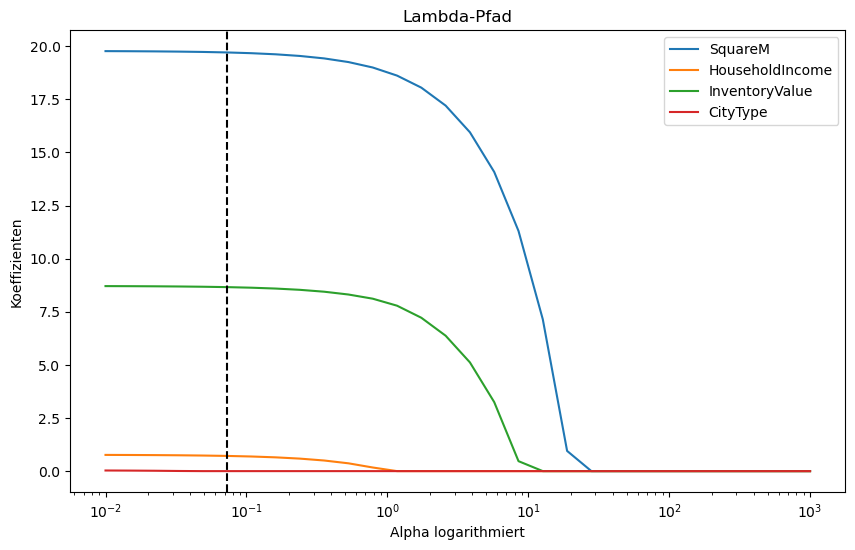

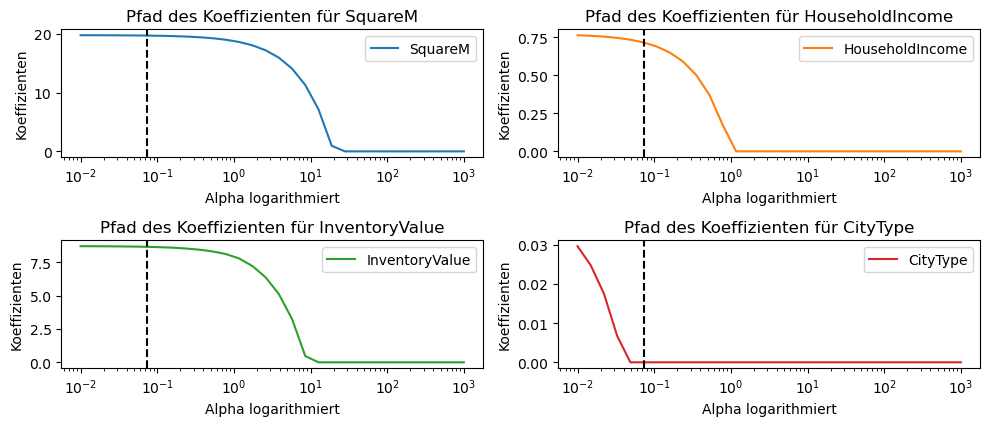

In [19]:
# Definieren einer Koeffizientenliste
coefs = []

# Fitten des Elastic Nets für optimales l1 und für alle alphas
for a in alpha_values:
    model = ElasticNet(alpha=a, l1_ratio=optimal_l1)
    model.fit(X_train_wodiscr, y_train)
    
    # Setzen der Koeffizienten
    coefs.append(model.coef_)

# Plotten des Lambda-Pfades
plt.figure(figsize=(10,6))
for i, coef in enumerate(np.array(coefs).T):
    plt.plot(alpha_values, coef, label = feature_names[i])
plt.title('Lambda-Pfad')
# Setzen einer Linie beim optimalen alpha
plt.axvline(optimal_alpha, color='black', linestyle='--')
plt.xlabel('Alpha logarithmiert')
plt.xscale('log')
plt.ylabel('Koeffizienten')
plt.legend()
plt.show()

# Plotten der einzelnen Lambda Pfade der Koeffizienten, um sie besser zu sehen
num_cols = 2
num_rows = len(feature_names) // num_cols + 1

# Für jedes Merkmal einen separaten Plot
plt.figure(figsize=(10,num_rows*2))

# Farben auf den großen Plot anpassen 
colourlist = ['C0', 'C1', 'C2', 'C3']
for i in range(len(feature_names)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(alpha_values, np.array(coefs)[:, i], label=feature_names[i], color=colourlist[i])
    plt.axvline(optimal_alpha, color='black', linestyle='--')
    plt.title('Pfad des Koeffizienten für ' + feature_names[i])
    plt.xlabel('Alpha logarithmiert')
    plt.xscale('log')
    plt.ylabel('Koeffizienten')
    plt.legend()
plt.tight_layout()
plt.show()

<ins>Kommentar</ins>: Die Lambda Pfade der einzelnen Features verlaufen alle am Anfang recht flach und fallen dann im Laufe der Zeit auf 0 ab. Bei den Merkmalen Haushaltseinkommen und City Type passiert dies recht schnell, da sie aber auch mit deutlich gereingeren Koeffizienten starten. Am langsamsten fällt das Merkmal Wohnfläche auf 0. Der optimale alpha Wert liegt bei allen Merkmalen außer City Type noch recht am Anfang des Abfallens. Bei City Type ist der Koeffizient beim optimalen alpha schon auf 0.  
Der Lambda-Pfad dient vor allem zur Modelloptimierung und zum Ausgleich zwischen Bias und Varianz. Der Lambda Pfad wirkt sich nicht auf indirekte Diskriminierung aus.

Sie dürfen die geschätzte Frequenz zur Plausibilisierungsprüfung heranziehen, aber nicht zum Training

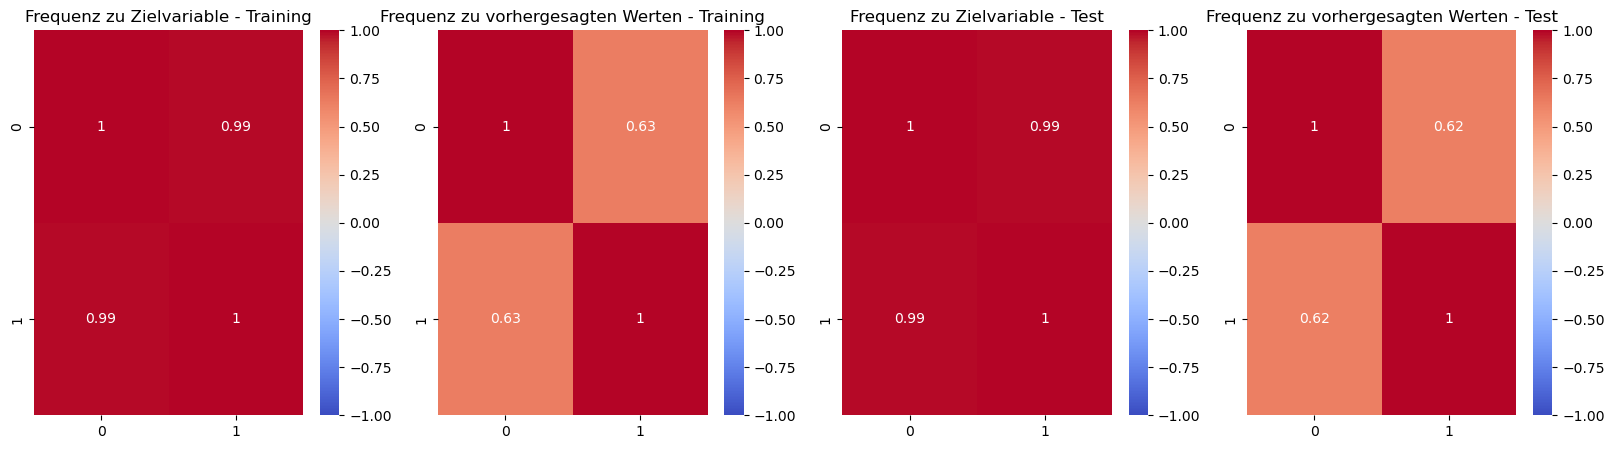

In [20]:
# Entfernen der diskriminierenden Spalten und des Merkmals Frequenz aus den Testdaten
X_test_wodiscr = X_test.drop(['freq','Gender','Age',], axis=1) 

# Vorhersagen der Werte auf den Trainingsdaten
y_pred_enet_train = enet.predict(X_train_wodiscr)

# Vorhersagen der Werte auf den Testdaten
y_pred_enet = enet.predict(X_test_wodiscr)

# Berechnen der einzelnen Korrelationen der Zielvariable mit der Frequenz
correlation_train = np.corrcoef(y_train, X_train['freq'])
correlation_test = np.corrcoef(y_test, X_test['freq'])

# Berechnen der einzelnen Korrelationen der vorhergesagten Werte mit der Frequenz
correlation_predicted_train = np.corrcoef(y_pred_enet_train, X_train['freq'])
correlation_predicted_test = np.corrcoef(y_pred_enet, X_test['freq'])

# Liste der Korrelationsmatrizen
correlations_with_freq = [correlation_train, correlation_predicted_train, 
                correlation_test, correlation_predicted_test]

# Titel für die Plots
titles = ["Frequenz zu Zielvariable - Training", "Frequenz zu vorhergesagten Werten - Training",
          "Frequenz zu Zielvariable - Test", "Frequenz zu vorhergesagten Werten - Test"]

# Plotten der vier Heatmaps nebeneinander
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    sns.heatmap(correlations_with_freq[i], annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(titles[i])

# Plotten
plt.show()

<ins>Kommentar</ins>: Die Korrelationen auf den vorhergesagten Werten sind geringer als die Korrelationen zu den Zielwerten. Dies ist zu erwarten, da das Modell ohne Frequenz trainiert. Würde die Korrelation ähnlich bleiben, hätten wir ein fast perfektes Vorhersagemodell.  
Die Korrelationen zu den vorhergesagten Werten auf den Trainings- und Testdaten sind sehr ähnlich, was auf ein recht gutes und stabiles Modell hinweist.

### Aufgabe 4. [localGLMnet] [20 Punkte]
Trainieren Sie ein Modell des Typs localGLMnet [2],[3] und vergleichen Sie es mit dem Modellen aus Aufgabe 2 und Aufgabe 3. Prüfen Sie mit den in [3] vorgeschlagenen Attention-Methoden und Shapley Value Contributions die funktionalen Zusammenhänge und vergleichen Sie diese mit den Modellen aus Aufgabe 3.

#### LocalGLMnet

In [21]:
# LocalGLMnet strukturieren
# Input Layer initialisieren
input = tf.keras.Input(shape=(4,), dtype="float32", name='Input')

# Attention Layer initialisieren
attention = input
attention = tf.keras.layers.Dense(units=128, activation="relu", name='Attention_3')(attention)
attention = tf.keras.layers.Dense(units=64, activation="relu", name='Attention_2')(attention)
attention = tf.keras.layers.Dense(units=32, activation="relu", name='Attention_1')(attention)
attention = tf.keras.layers.Dense(units=4, activation="linear", name="Attention")(attention)

# Response Schicht, Verbindung von Attention layer mit Input Layer
response = tf.keras.layers.Dot(axes=1, name='Response_1')([input, attention])
response = tf.keras.layers.Dense(units=1, activation="linear", name="Response")(response)

# Modell kompilieren
local_glm_net = tf.keras.Model(inputs=input, outputs=response)
local_glm_net.compile(loss="mse", optimizer="nadam")

# Early Stopping hinzufügen, um zu stoppen, falls val_loss keine Verbesserung in 3 Epochen hintereinander aufweist
callback = EarlyStopping(monitor='val_loss', patience=3)

# Zusammenfassung der Statistiken des Modells
local_glm_net.summary()

# Modell trainieren
history = local_glm_net.fit(X_train_wodiscr, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callback])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_3 (Dense) │ (None, 128)       │        640 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_2 (Dense) │ (None, 64)        │      8,256 │ Attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_1 (Dense) │ (None, 32)        │      2,080 │ Attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention (Dense)   │ (None, 4)         │        132 │ Attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Response_1 (Dot)    │ (None, 1)         │          0 │ Input[0][0],      │
│                     │                   │            │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Response (Dense)    │ (None, 1)         │          2 │ Response_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,110 (43.40 KB)

 Trainable params: 11,110 (43.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3780.9214 - val_loss: 1064.1249
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1035.3474 - val_loss: 863.7965
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 850.6313 - val_loss: 738.9541
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 734.5120 - val_loss: 668.6415
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 672.3549 - val_loss: 633.7343
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 642.4331 - val_loss: 614.8851
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 625.1369 - val_loss: 603.9174
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 614.5640 - val_loss: 597.8049
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 607.6851 - val_loss: 595.1121
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 603.9457 - val_loss: 592.9394
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 600.6406 - val_loss: 591.8403
Epoch

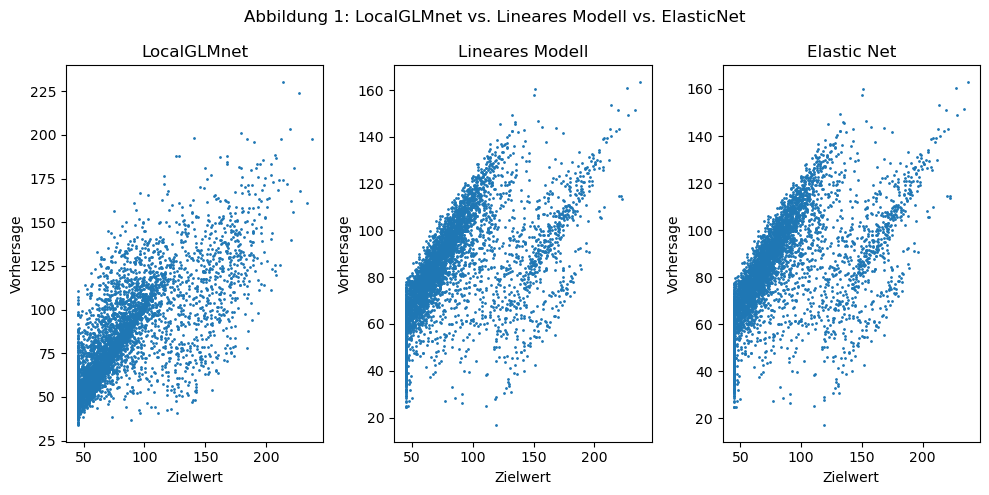

MSE LocalGLMnet: 597.6454305666884
MSE Lineares Modell: 924.4133817499375
MSE Elastic Net: 924.4133114916068


In [22]:
# Vorhersage mit localGLMnet 
y_pred_local = local_glm_net.predict(X_test_wodiscr, verbose=0)

# Plotten der Vorhersage gegen Zielwerte
fig_performance = plt.figure(tight_layout=True, figsize=(10, 5))
spec = GridSpec(ncols=3, nrows=1, figure=fig_performance)
axs_perf = [
    fig_performance.add_subplot(spec[0, 0:1]),
    fig_performance.add_subplot(spec[0, 1:2]),
    fig_performance.add_subplot(spec[0, 2:3]),
]

# Plotten sowohl für LocalGLMnet, Lineares Modell und Elastic Net
axs_perf[0].scatter(y_test, y_pred_local, s=1)
axs_perf[0].set_title("LocalGLMnet")
axs_perf[1].scatter(y_test, y_pred_woall, s=1)
axs_perf[1].set_title("Lineares Modell")
axs_perf[2].scatter(y_test, y_pred_enet, s= 1)
axs_perf[2].set_title("Elastic Net")

# Setzen der Ploteigenschaften
for ax in axs_perf:
    ax.set_xlabel("Zielwert")
    ax.set_ylabel("Vorhersage")

# Titel des Plots
fig_performance.suptitle("Abbildung 1: LocalGLMnet vs. Lineares Modell vs. ElasticNet")

# Plotten
plt.show()

# Berechnungs und Ausgabe des Mean Squared Errors
print(f'MSE LocalGLMnet: {str(metrics.mean_squared_error(y_test, y_pred_local))}')
print(f'MSE Lineares Modell: {str(metrics.mean_squared_error(y_test, y_pred_woall))}')
print(f'MSE Elastic Net: {str(metrics.mean_squared_error(y_test, y_pred_enet))}')

<ins>Kommentar</ins>: Der MSE des LocalGLMnets ist deutlich besser als der MSE des linearen Modells und des Elastic Nets. Die beiden MSE Werte des linearen Modells und des Elastic Nets sind fast gleich. Zudem kann man auf den obigen Plots erkennen, dass die Vorhersagen im Vergleich zu den Zielwerten etwas zentrierter und mehr an der Diagonale sind, als bei den anderen beiden Modellen. Insgesamt lässt sich also schließen, dass das LocalGLMnet besser performed als die beiden anderen Modelle.

##### Attention Plots

In [23]:
# Kantengewichte, sowie den Bias für jede Schicht
weights = local_glm_net.get_weights()
for i in weights:
    print(i.shape, end=" | ")

(4, 128) | (128,) | (128, 64) | (64,) | (64, 32) | (32,) | (32, 4) | (4,) | (1, 1) | (1,) | 

In [24]:
# Neues Model ohne Response-Schicht, ermöglicht Auslesen der Attention Gewichte
weights_local_glm = tf.keras.Model(inputs=local_glm_net.input, outputs=local_glm_net.get_layer(name="Attention").output)

# Gewichte bestimmen
beta_x = weights_local_glm.predict(X_test_wodiscr, verbose = 0)

# Skalierung der Attention-Gewichte mithilfe des Gewichts der Response Schicht
beta_x_scaled = beta_x * weights[8]

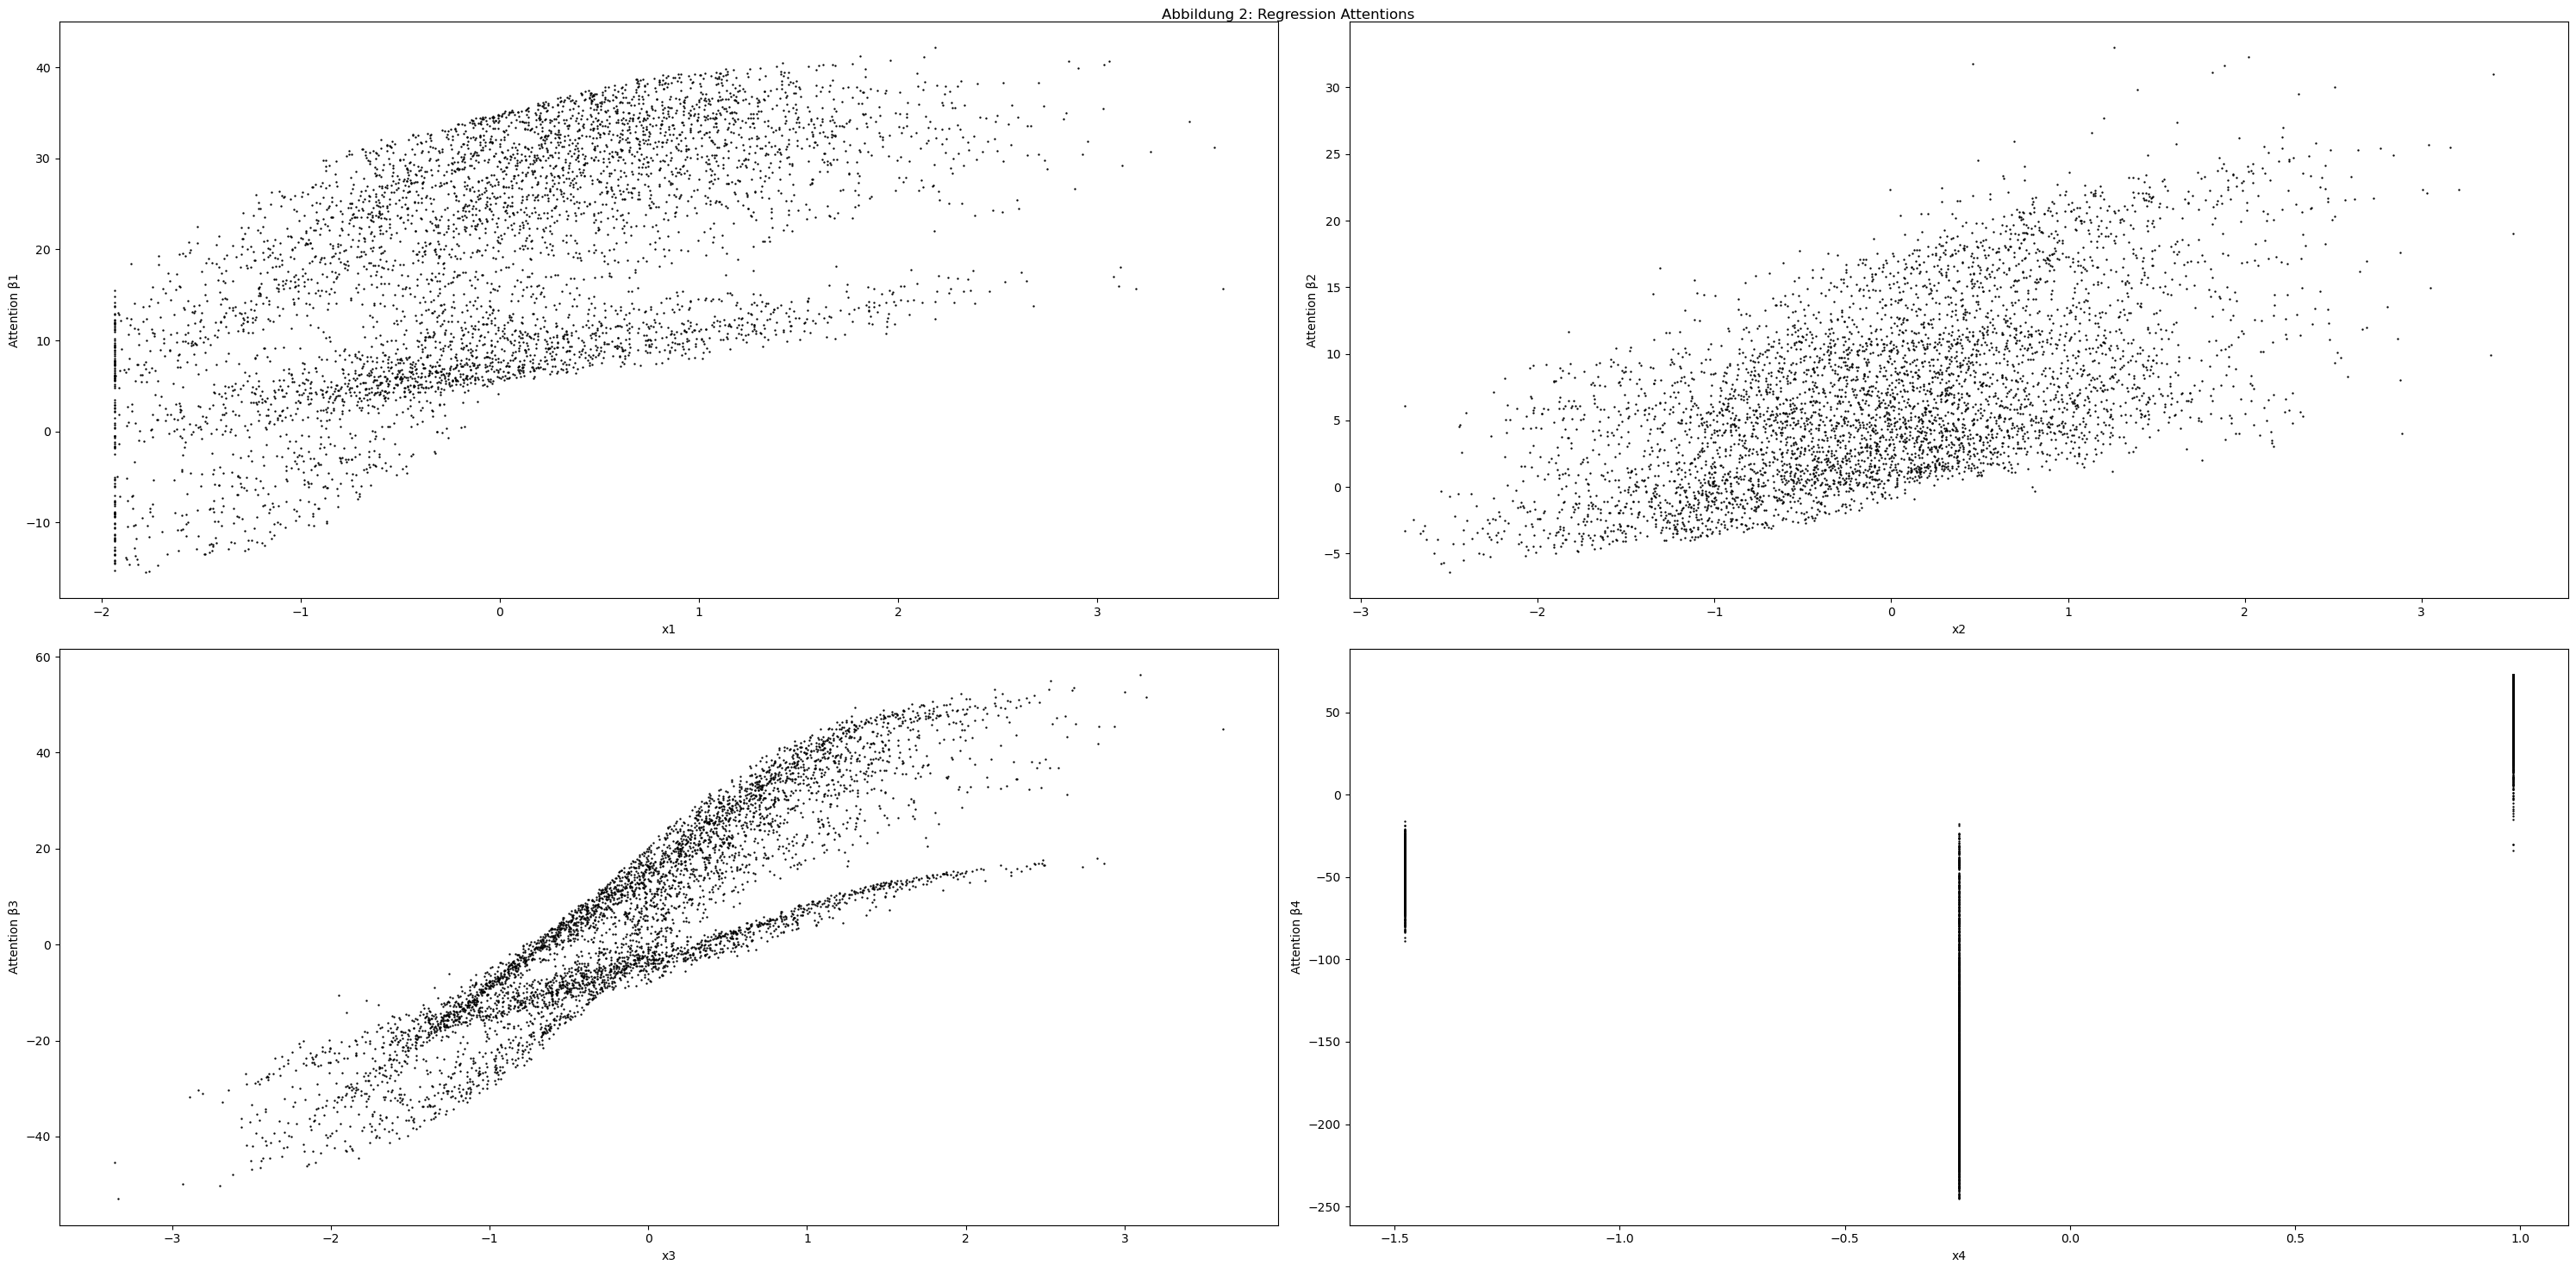

In [25]:
# Attention Plot
fig_attention = plt.figure(tight_layout=True, figsize=(30, 15))

# Gliederung der Subplots
spec = GridSpec(ncols=2, nrows=2, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 0:1])
ax2_att = fig_attention.add_subplot(spec[0, 1:2])
ax3_att = fig_attention.add_subplot(spec[1, 0:1])
ax4_att = fig_attention.add_subplot(spec[1, 1:2])
axs_att = [ax1_att, ax2_att, ax3_att, ax4_att]

# Einen Subplot pro Input Feature erstellen
for i in range(len(axs_att)):

    # Werte der Inputfeatures zu Attention Gewichten
    axs_att[i].scatter(X_test_wodiscr.iloc[:, i], beta_x_scaled[:, i], s=0.5, c="black")
    axs_att[i].set_xlabel("x" + str(i + 1))
    axs_att[i].set_ylabel("Attention β" + str(i + 1))

# Titel des Plots
fig_attention.suptitle("Abbildung 2: Regression Attentions")

# Plotten
plt.show()


<ins>Kommentar</ins>: In diesem Plot lassen sich verschiedene funktionale Zusammenhänge und Interaktionen erkennen:  
<ins>β1,β2</ins>: Attention-Gewichte sind ungleich 0. Diese Merkmale (Wohnfläche, Haushaltseinkommen) haben einen Einfluss auf die Vorhersage. Zudem kommt es zu lateralen Verzerrungen, was angibt, dass die Merkmale auch Interaktionen mit anderen Inputvariablen haben.  
<ins>β3</ins>: Hier enstehen wenig laterale Verzerrungen, sodass dieses Merkmal (Inventarwert) kaum Interaktionen mit anderen Inputvariablen hat.  
<ins>β4</ins>: Hier gibt es keine Verzerrungen und somit keine Interaktionen. Man erkennt deutlich die 3 vertikalen Linien, die die 3 Ausprägungen des Merkmals City Type repräsentieren.

In [26]:
# Ausgabe der Attention Outputs
intermediate_model = tf.keras.Model(inputs=local_glm_net.input, outputs=local_glm_net.get_layer("Attention").output)
attention_output = intermediate_model.predict(X_test_wodiscr, verbose= 0)
print(f'Attention output: {attention_output}')

Attention output: [[  20.577797      0.85181034   -4.808624   -103.71663   ]
 [   2.4392047    13.622026     10.1777115   -51.40488   ]
 [  19.764353      3.8380222    18.91318      38.376743  ]
 ...
 [  15.794824     -0.25301233  -15.559587   -103.28582   ]
 [  20.277643      2.5424914    -3.3199377   -94.699875  ]
 [  15.506112      0.93784034   -1.5997852    40.98422   ]]


##### Shapley Values

<ins>Kommentar</ins>: Da SHAP einen Dataloader nutzt, würde eine Berechnung mit vollem Trainings- und Testset die Laufzeit und Rechenkapazität übersteigen. Somit clustern wir die jeweiligen Werte über kMeans zu 100 Clustern und nutzen diese Clustermittelpunkte als repräsentatives Datenset.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
44/44 ━━━━━━━━━━━━━━

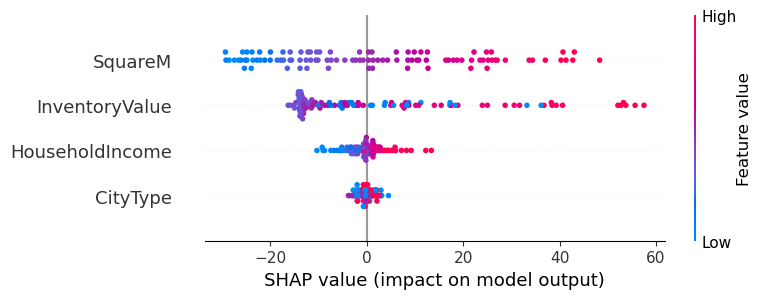

In [27]:
# Shapley Values
# Setzen der Merkmalsnamen
feature_names = X_train_wodiscr.columns.tolist()

# Clustern der Datensets um Speicher- und Rechenleistungsprobleme zu umgehen
kmeans_samples_train = shap.kmeans(X_train_wodiscr, 100)
kmeans_samples_test = shap.kmeans(X_test_wodiscr,100)

# Erstellen eines Shapley Objektes
shapley_explainer = shap.KernelExplainer(local_glm_net.predict, kmeans_samples_train, feature_names=feature_names)

# Berechnen der Shapley Werte
shap_values = shapley_explainer.shap_values(kmeans_samples_test.data)

# Plotten der Shapley Values
shap.summary_plot(np.squeeze(shap_values), kmeans_samples_test.data, feature_names=feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

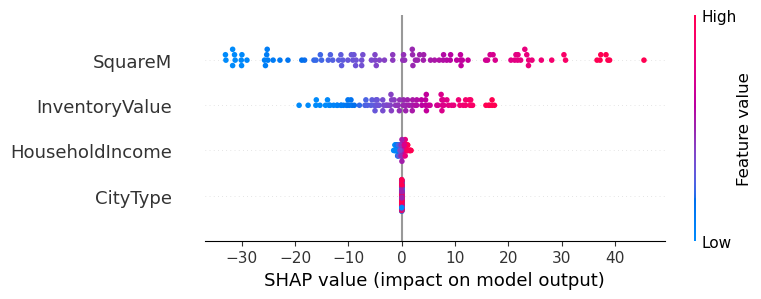

In [28]:
# Shapley Values für das ElasticNet
# Erstellen eines Shapley Objektes
shapley_explainer_EN = shap.KernelExplainer(enet.predict, kmeans_samples_train, feature_names=feature_names)

# Berechnen der Shapley Werte
shap_values_EN = shapley_explainer_EN.shap_values(kmeans_samples_test.data)

# Plotten der Shapley Werte
shap.summary_plot(np.squeeze(shap_values_EN), kmeans_samples_test.data, feature_names=feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

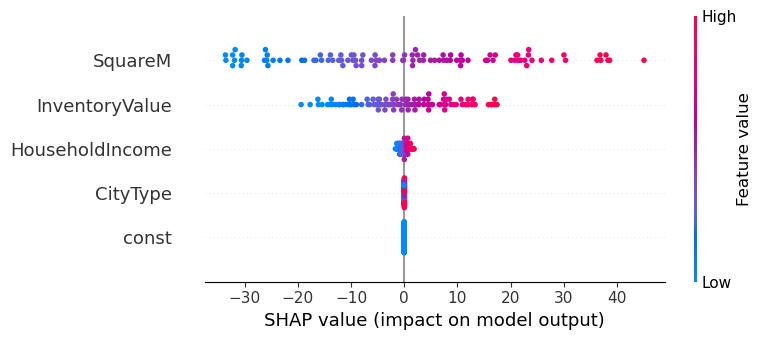

In [29]:
# Shapley Values für das lineare Modell
# Hinzufügen eines Intercepts, da das lineare Modell diesen voraussetzt
kmeans_samples_train_const = sm.add_constant(kmeans_samples_train.data)
kmeans_samples_test_const = sm.add_constant(kmeans_samples_test.data)

# Erstellen eines Shapley Objektes
shapley_explainer_linear_model = shap.KernelExplainer(linear_model3.predict, kmeans_samples_train_const, feature_names=['const']+feature_names)

# Berechnen der Shapley Werte
shap_values_linear_model = shapley_explainer_linear_model.shap_values(kmeans_samples_test_const)

# Plotten der Shapley Werte
shap.summary_plot(np.squeeze(shap_values_linear_model), kmeans_samples_test_const, feature_names=['const']+feature_names)

<ins>Kommentar</ins>: Vergleich der Shapley Values der 3 Modelle  
Allgemein sind Shapley Werte eine Methode zur Erklärung von Vorhersagen einzelner Modelle. Diese Werte messen den Beitrag jedes Features zur Vorhersage für jede einzelne Beobachtung.
Shapley Plots geben die Feature Wichtigkeit, die Wirkungsrichtung, den Feature Wert, die Größe des Effektes und die Verteilung der Effekte an.  
Die Position des Features auf der y-Achse bestimmt die jeweilige Wichtigkeit.
Bei allen 3 Modellen bilden Wohnfläche und dann Inventarwert die höchste Wichtigkeit. Bei dem linearen Modell und dem Elastic Net folgen dann Haushaltseinkommen und City Type (und Konstante beim linearen Modell), beim LocalGLMnet ist die Reihenfolge der letzten beiden Merkmale getauscht.  
Die Farbe der Datenpunkte gibt die Wirkungsrichtung des Features an. Bei rötlicheren Farbtönen erhöht das Merkmal den Zielwert, bei bläulicheren Farbtönen senkt das Merkmal den Zielwert. Beim linearen Modell und bei dem Elastic Net sind die Wirkungsrichtungen recht gleich verteilt. Links von der Nulllinie befinden sich eher bläuliche Farbtöne, rechts davon eher rötliche. Bei dem LocalGLMnet sind die Farben bei Inventarwert und CityType recht durchgemischt, bei den anderen beiden Merkmalen auch eher sortiert.  
Die Position der Datenpunkte auf der x-Achse gibt an, ob der Effekt des Merkmals positiv oder negativ ist. Bei dem linearen Modell und dem Elastic Net sind diese Werte recht gleichverteilt auf den Seiten der Nulllinie. Die beiden Merkmale City Type und Inventarwert beim LocalGLMnet clustern sich zum Teil auf der linken Seite.  
Der Abstand eines Punktes von der vertikalen Nulllinie im Diagramm sagt uns, wie stark die Wirkung dieses Feature-Wertes ist. Dies ist bei den beiden Modellen Lineare Regression und Elastic Net sehr gleichverteilt, während es beim LocalGLMnet links eher geclusterte Datenpunkte gibt und rechts davon eine Verteilung der Datenpunkte.  
Mehr Punkte in einem Gebiet des Diagramms bedeuten, dass es mehr Datenpunkte mit den entsprechenden Werten gibt. Bei allen drei Modellen gibt es clusterartige Datenpunktwolken bei den Merkmalen Haushaltseinkommen und City Type. Beim LocalGLMnet ist zusätzlich auch der Inventarwert links der Nulllinie geclustert.

### Aufgabe 5:[Vermeidung indirekter Diskriminierung] [35 Punkte]
Trainieren Sie mindestens zwei Modelle, die die indirekte Diskriminierung beseitigen können und bewerten Sie, ob und wie gut dies gelingt. Konzentrieren Sie sich auf die Vermeidung von indirekter Diskriminierung beim Merkmal Alter. Vergleichen Sie dazu die Basisprämie mit der korrigierten Prämie sowohl auf Einzelvertragsebene als auch auf einer geeigneten aggregierten Ebene. Untersuchen Sie Ihre Ansätze mit geeigneten Visualisierungen und Erklärbarkeitsansätzen, und diskutieren Sie die Erklärbarkeit der Methoden hinsichtlich der Frage nach direkter und indirekter Diskriminierung.

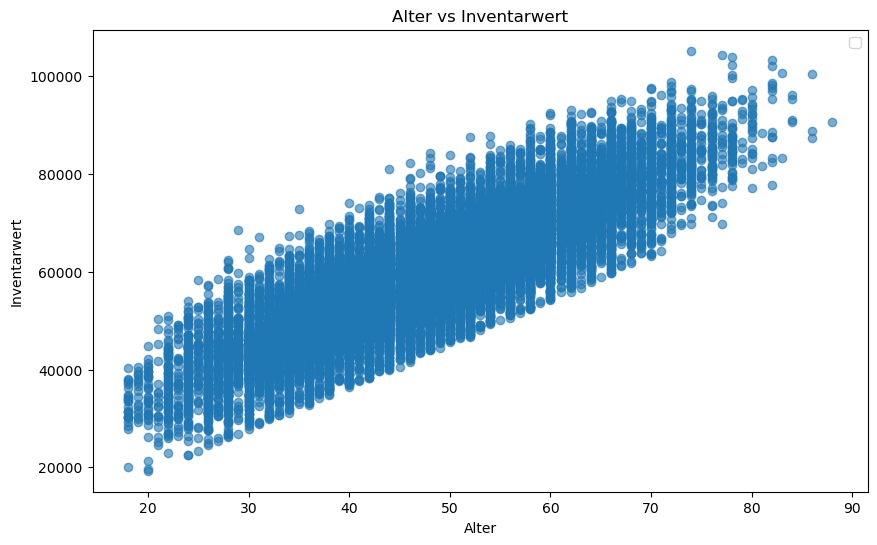

In [30]:
# Plotten des Ersatzmerkmals Inventarwert für Alter, welches indirekt diskriminiert
inventory_value = dfdata_raw['InventoryValue']
plt.figure(figsize=(10, 6))
plt.scatter(dfdata_raw['Age'], inventory_value, alpha=0.6)
plt.xlabel('Alter')
plt.ylabel('Inventarwert')
plt.title('Alter vs Inventarwert')
plt.legend()
plt.show()

<ins>Kommentar</ins>: Man erkennt hier gut, dass mit steigendem Alter der Inventarwert ansteigt. Dies zeigt eine Abhängigkeit des Merkmals Inventarwert von dem Merkmal Alter.

#### Erstes Modell gegen indirekte Diskriminierung: Correlation Remover beim linearen Modell

In [31]:
# Entferne Korrelationen zwischen verbleibenden Merkmalen und diskriminierenden Merkmalen
remover_correlations = CorrelationRemover(sensitive_feature_ids=['Gender', 'Age'])

# Index des sensitive Merkmals
X_unscaled = dfdata_raw.copy(deep=True)

# Entfernen der Zielvariable aus den erklärenden Variablen
X_unscaled = X_unscaled.drop(['Response'], axis=1)

# Entfernen der Korrelationen aus den erklärenden Variablen und Entfernen der sensitiven Merkmale
X_wo_indir_discr = remover_correlations.fit_transform(X_unscaled)

# Zusammenfügen der Merkmalsnamen und der Daten zu einem DataFrame
X_columns = X_unscaled.columns
X_wo_indir_discr_df = pd.DataFrame(X_wo_indir_discr, columns=X_columns[2:])


In [32]:
#Vorbereitung des Datensatzes
# Erstellen eines StandardScaler Objektes
scaler_new = StandardScaler()

# Skalieren der nicht diskriminierenden Daten
X_wo_indir_discr_scaled = scaler_new.fit_transform(X_wo_indir_discr_df)
X_wo_indir_discr_scaled = pd.DataFrame(X_wo_indir_discr_scaled, columns = X_wo_indir_discr_df.columns)

# Entfernen des Merkmals Frequenz
X_wo_indir_discr_scaled = X_wo_indir_discr_scaled.drop(['freq'], axis = 1)

# Speichern des disrkiminierenden Merkmals Alter
age = dfdata_raw['Age'] 

# Split des Datensatzes in Trainings- und Testdaten
X_wo_indir_discr_train, X_wo_indir_discr_test = train_test_split(X_wo_indir_discr_scaled, test_size=0.2, random_state=seed)
age_train, age_test = train_test_split(age, test_size=0.2, random_state=seed)

In [33]:
# Hinzufügen des Intercepts zu den Trainings- und Testdaten
X_wo_indir_discr_train = sm.add_constant(X_wo_indir_discr_train)
X_wo_indir_discr_test = sm.add_constant(X_wo_indir_discr_test)

# Erstellen eines linearen Modells mit den Datensätzen ohne indirekte Diskriminierung
linear_model_wo_indir_discr = sm.OLS(y_train, X_wo_indir_discr_train).fit()

# Zusammenfassung der Modellstatistiken
print(linear_model_wo_indir_discr.summary())

# Vorhersage der Response Werte
y_pred_linear_wo_indir_discr = linear_model_wo_indir_discr.predict(X_wo_indir_discr_test)

# Berechnung MSE
mse_linear_fair = mean_squared_error(y_test, y_pred_linear_wo_indir_discr)

# Berechnung und Ausgabe des MSE ohne indirekte Diskriminierung
print(f'MSE des linearen Modells ohne indirekte Diskriminierung: {mse_linear_fair}')

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     1953.
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        18:17:12   Log-Likelihood:                -97488.
No. Observations:               20000   AIC:                         1.950e+05
Df Residuals:                   19995   BIC:                         1.950e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.8325      0.224    3

<ins>Kommentar</ins>: Der MSE dieses linearen Modells ohne indirekte Diskriminierung ist etwas schlechter als der MSE des normalen linearen Modells ohne direkte Diskriminierung (924). Zudem ist auch das R^2 leicht gesunken.  
In diesem Modell hat das Merkmal Wohnfläche den größten Koeffizienten. Das Merkmal Inventarwert hat einen hohen p-Wert und ist somit für das Modell eher insignifikant.

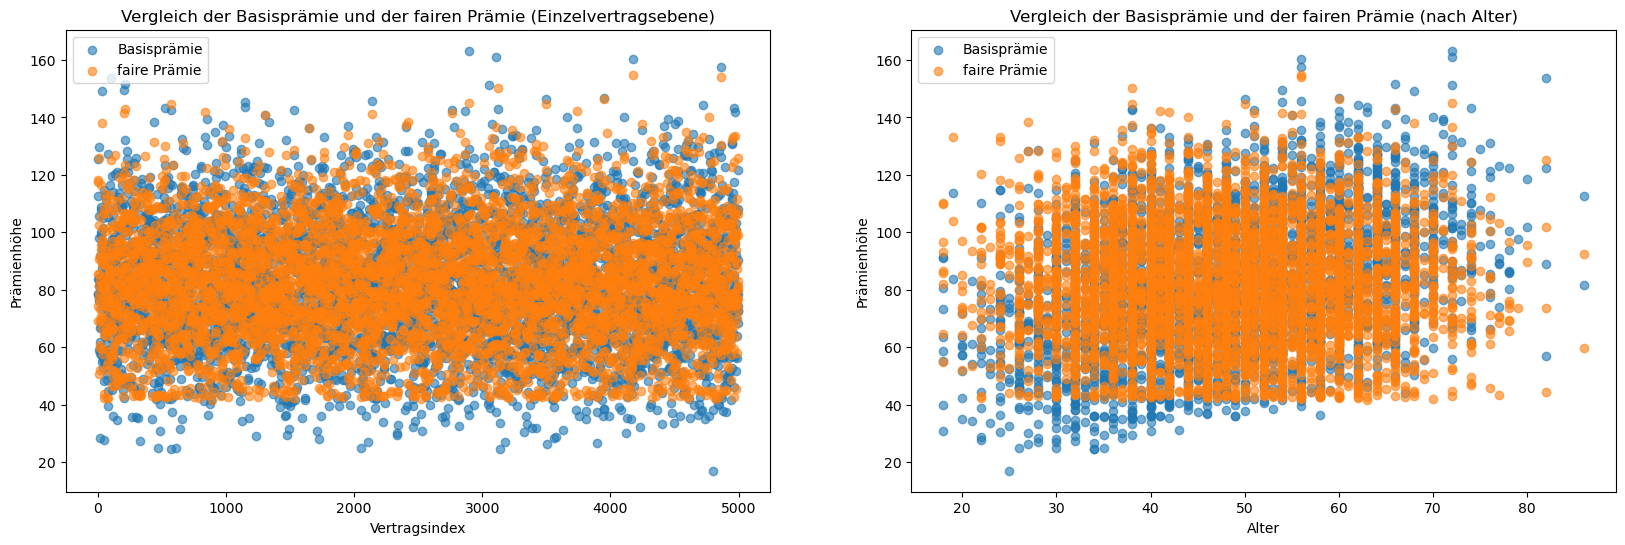

Durchschnittliche Basisprämie: 82.04325052474253
Durchschnittliche faire Prämie: 82.3702415464183


In [34]:
# Vergleich zwischen linearem Modell ohne direkte Diskriminierung (Basisprämie) und linearem Modell ohne indirekte Diskriminierung (Faire Prämie)
comparison_base_fair(y_pred_woall, y_pred_linear_wo_indir_discr, age_test)

<ins>Kommentar</ins>: Man erkennt an den Graphiken, dass die fairen Prämien etwas kompakter sind, als die Basisprämien. Die unteren Prämien haben einen Aufschlag erhalten und die hohen Prämien einen Abschlag. Insbesondere im rechten Plot erkennt man sehr gut, dass die fairen Prämien über das Alter nun deutlich stabiler sind. Die Basisprämien inks unten und rechts oben sind ausgeglichen worden und befinden sich nun alle durchgehend auf einem gleichbleibenderen Niveau.  
Somit ist die durchschnittliche faire Prämie leicht höher als die durchschnittliche Basisprämie, da vor allem die vielen jüngeren Alter einen Aufschlag bekommen haben.

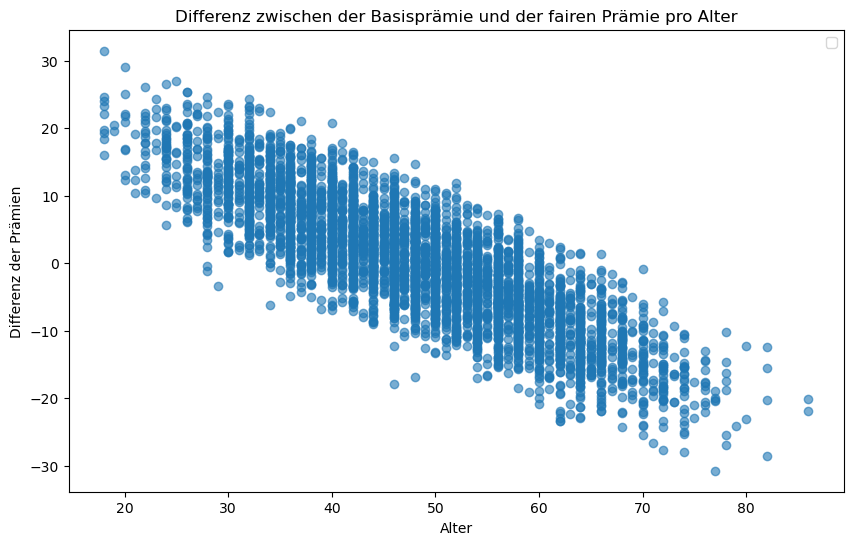

In [35]:
# Plotten der Differenzen pro Alter
scatterplot_differences(y_pred_woall, y_pred_linear_wo_indir_discr, age_test)

<ins>Kommentar</ins>: Auch hier erkennt man, dass die Aufschläge auf die Basisprämie mit dem Alter abnehmen und dann ab ca. 45 Jahren zu steigenden Abschlägen werden. Dies sollte sehr gut bei der indirekten Diskriminierung durch Alter helfen und dem steigenden Inventarwert bei steigendem Alter entgegenwirken.

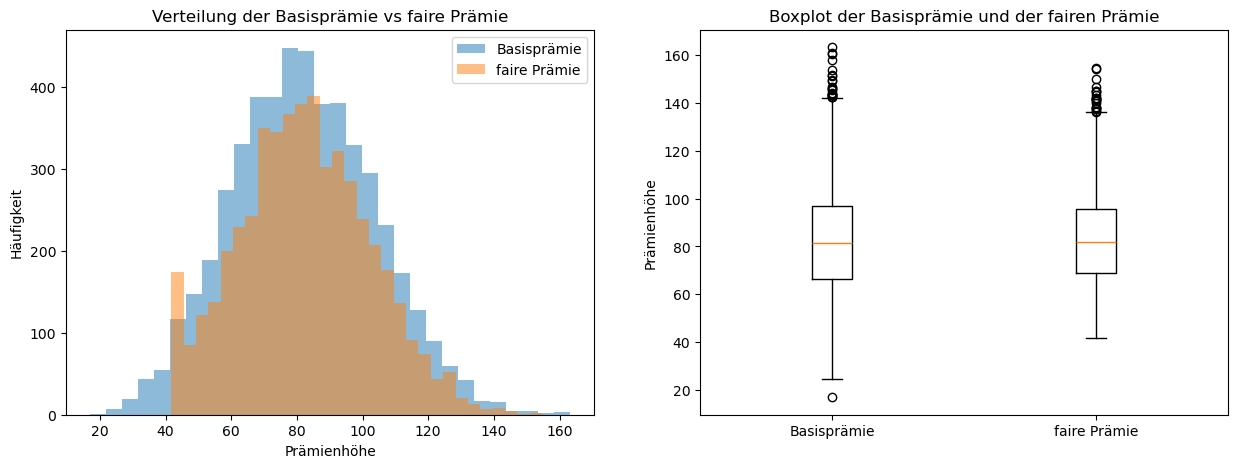

In [36]:
# Plotten der Basis- vs. fairen Prämie auf aggregierter Ebene
aggregated_plots(y_pred_woall, y_pred_linear_wo_indir_discr)

<ins>Kommentar</ins>: Auch hier erkennt man, dass die Häufigkeiten der fairen Prämien etwas "zusammen gedrückt" sind. Die Prämienhöhe setzt höher ein, hört aber etwas geringer auf. Man erkennt einen kleinen Ausreißer der Häufigkeiten bei den Prämien knapp über 40. Dies sind die vielen korrigierten Prämien der jungen Alter. Auch im Boxplot erkennen wir einen etwas zusammengeschobeneren Graphen und weniger hohe Ausreißer bei der fairen Prämie.

#### Zweites Modell gegen indirekte Diskriminierung: adversarielles Modell beim Elastic Net

In [37]:
# Entfernen der nicht zu verwendenden Merkmale
X_adv = dfdata_raw.drop(columns=['Response', 'freq', 'Gender', 'Age']) 

# Standardisieren der Merkmale
scaler = StandardScaler()
X_adv = scaler.fit_transform(X_adv)

# Splitten der Daten in Trainings- und Testdaten
X_adv_train, X_adv_test = train_test_split(X_adv, test_size=0.2, random_state=seed)

# Definieren des Hauptmodells (Elastic Net), Verwendung der optimalen Werte aus Aufgabe 3
main_enet = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1)

# Definieren des adversariellen Modells
adversarial_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000, random_state=seed)

# Trainieren des Hauptmodells
main_enet.fit(X_adv_train, y_train)

# Vorhersagen des Hauptmodells
y_pred_main = main_enet.predict(X_adv_train)

# Trainieren des adversariellen Modells, um das Alter vorherzusagen
adversarial_model.fit(X_adv_train, age_train)

# Vorhersagen des adversariellen Modells für das Merkmal Alter
age_pred_adversarial = adversarial_model.predict(X_adv_train)

# Berechnen der Genauigkeit des adversariellen Modells
accuracy = accuracy_score(age_train, age_pred_adversarial)
print(f'Genauigkeit des adversariellen Modells: {accuracy}')

Genauigkeit des adversariellen Modells: 0.12605


<ins>Kommentar</ins>: Die Genauigkeit des adversariellen Modells ist recht niedrig mit ca. 12.6%. Dies lässt schließen, dass das adversarielle Modell das Alter mit den verbleibenden Merkmalen nicht allzu gut vorhersagen kann.  
In Bezug auf indirekte Diskriminierung ist dies ein gutes Zeichen. Das Alter steckt also nur sehr geringfügig in den anderen Merkmalen drin und somit ist die indirekte Diskriminierung in der Basis auch nicht allzu hoch.

In [38]:
# Anpassen des Hauptmodells, um die Fairness zu verbessern, Anwenden der Fairness Strafe
main_enet.coef_ += 20 * adversarial_model.coefs_[0].mean(axis=1) 

# Berechnen der Prämie aus dem Modell ohne indirekte Diskriminierung (Hauptmodell)
adjusted_enet_premium = main_enet.predict(X_adv_test)

# Berechnen und Ausgeben des Mean Squared Error
mse_enet_fair = mean_squared_error(y_test, adjusted_enet_premium)
print(f'Mean Squared Error für die faire Prämie: {mse_enet_fair}')

Mean Squared Error für die faire Prämie: 927.9727881223604


<ins>Kommentar</ins>: Der Mean Squared Error ist im Vergleich zum Basis Elastic Net (MSE von 924) nur sehr leicht erhöht.

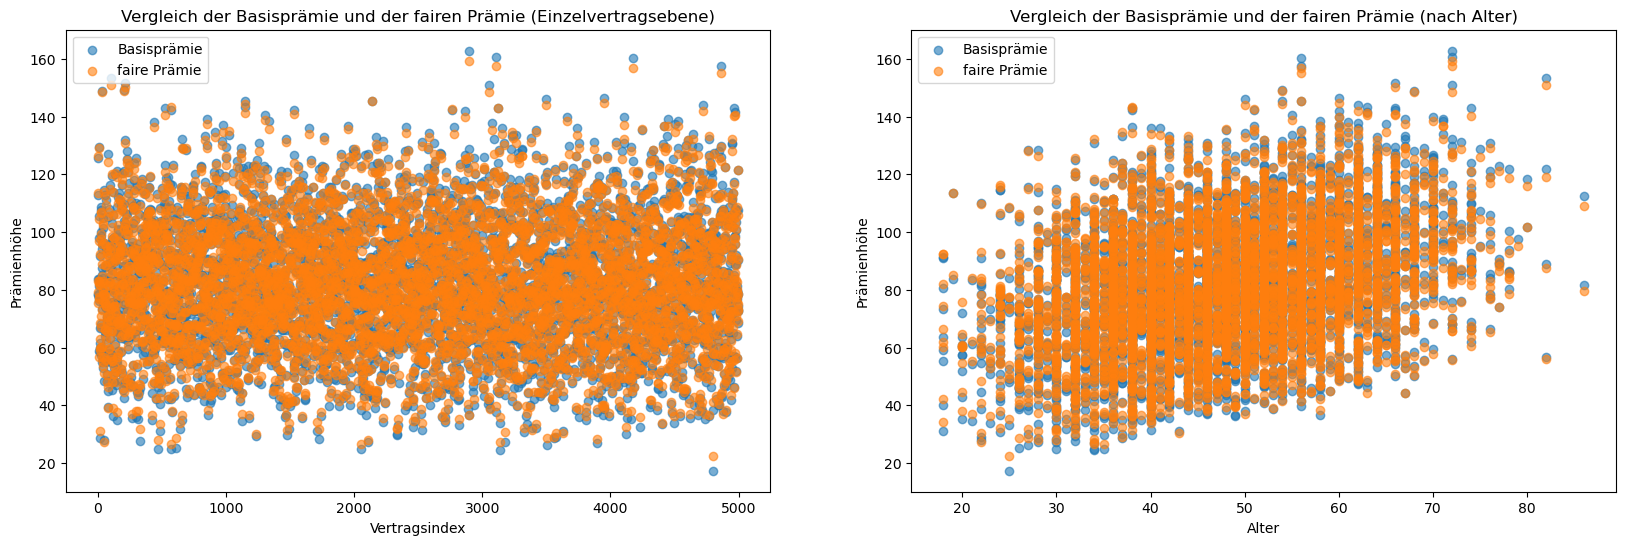

Durchschnittliche Basisprämie: 82.04434367995593
Durchschnittliche faire Prämie: 82.05459895374065


In [39]:
# Vergleich zwischen Elastic Net ohne direkte Diskriminierung (Basisprämie) und Elastic Net ohne indirekte Diskriminierung (Faire Prämie)
comparison_base_fair(y_pred_enet, adjusted_enet_premium, age_test)

<ins>Kommentar</ins>: Man erkennt an den Graphiken, dass die fairen Prämien etwas eingeschränkter sind, als die Basisprämien. Die unteren Prämien haben einen Aufschlag erhalten und die hohen Prämien einen Abschlag. Man erkennt im rechten Plot eine etwas weniger stark steigende Wolke. Diese ist für die faire Prämie leicht abgeflacht. Im Vergleich zum fairen linearen Modell erkennt man die Abflachung nicht ganz so klar. Die Prämien gleichen sich etwas an und verändern sich über den Verlauf des Alters weniger stark als vorher.
Somit ist die durchschnittliche faire Prämie ganz leicht höher als die durchschnittliche Basisprämie, da vor allem die vielen jüngeren Alter einen Aufschlag bekommen haben.

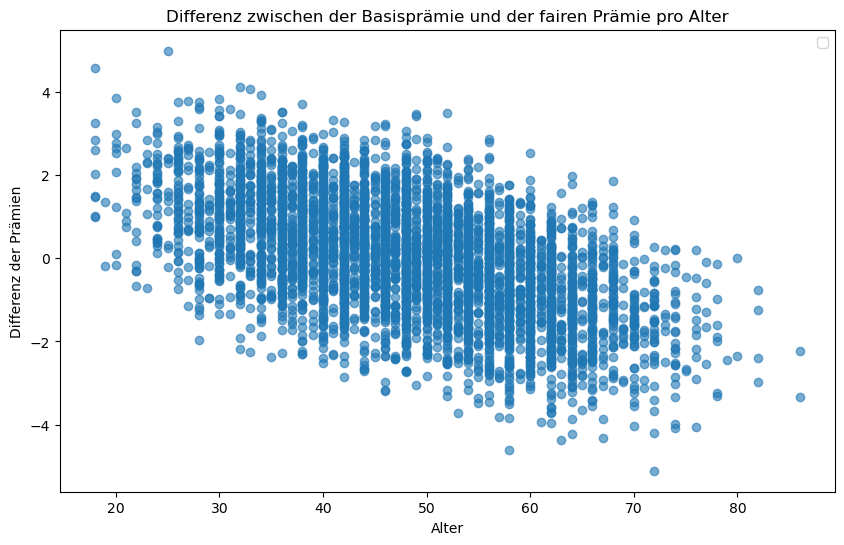

In [40]:
# Plotten der Differenzen pro Alter
scatterplot_differences(y_pred_enet, adjusted_enet_premium, age_test)

<ins>Kommentar</ins>: Auch hier erkennt man, dass die Aufschläge auf die Basisprämie mit dem Alter abnehmen und dann ab ca. 45 Jahren zu steigenden Abschlägen werden. Dies sollte sehr gut bei der indirekten Diskriminierung durch Alter helfen und dem steigenden Inventarwert bei steigendem Alter entgegenwirken.

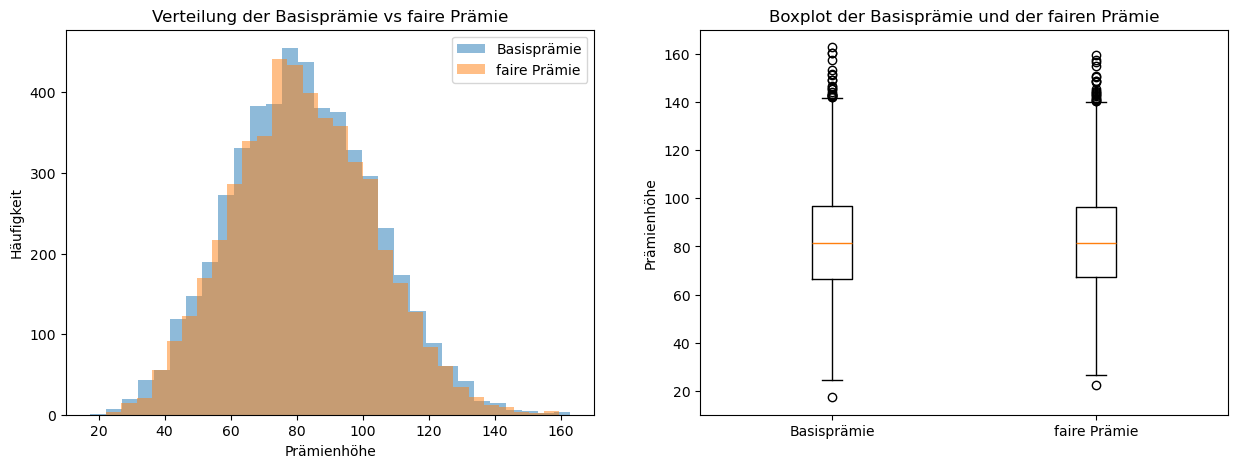

In [41]:
# Plotten der Basis- vs. fairen Prämie auf aggregierter Ebene
aggregated_plots(y_pred_enet, adjusted_enet_premium)

<ins>Kommentar</ins>: Auch hier erkennt man, dass die Häufigkeiten der fairen Prämien etwas "zusammen gedrückt" sind. Die Prämienhöhe setzt höher ein, hört aber etwas geringer auf. Auch im Boxplot erkennen wir einen etwas zusammengeschobeneren Graphen und weniger hohe Ausreißer bei der fairen Prämie.

#### Drittes Modell gegen indirekte Diskriminierung: Custom Loss-Funktion LocalGLMnet

Verändern Sie für Ihr localGLMnet die Loss-Funktion auf geeignete Weise, sodass das Modell diskriminierungsmindernd wirkt, wenn möglich auch gegen indirekte Diskriminierung.

In [42]:
# individuelle Loss Funktion (Definition hier, um es besser mit der Aufgabe in Verbindung zu bringen)
def custom_loss(y_true, y_pred):
    # Berechnung des Mean Squared Errors
    mse = K.mean(K.square(y_true - y_pred))
    
    # Berechnung des Mittelwerts für Alter und Vorhersagen
    age = tf.convert_to_tensor(X_test_wofreq['Age'], dtype=tf.float32)
    y_pred_mean = K.mean(y_pred)
    age_mean = K.mean(age)

    # Kovarianz zwischen den Abständen der Vorhersagen und des Alters
    covariance = K.mean((y_pred - y_pred_mean) * (age - age_mean))

    # Standardabweichung Alter und Vorhersage
    y_pred_std = K.std(y_pred)
    age_std = K.std(age)

    # Berechnung der Korrelation zwischen den Vorhersagen und dem Alter
    correlation = covariance / (y_pred_std * age_std)
    
    # Strafe für Diskriminierung
    penalty = K.square(correlation)
    
    # Loss Funktion mit Strafe und Gewichtungsfaktor für die Strafe
    return mse + 0.2 * penalty

In [43]:
# Modell kompilieren mit Custom Loss-Funktion
local_glm_net.compile(loss=custom_loss, optimizer="nadam")

In [44]:
# Modell trainieren
history = local_glm_net.fit(X_train_wodiscr, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callback])

# Vorhersage mit localGLMnet
y_pred_local_fair = local_glm_net.predict(X_test_wodiscr)

# Berechnen des MSE der fairen Prämie
mse_local_fair = mean_squared_error(y_test, y_pred_local_fair)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 593.3965 - val_loss: 591.5112
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 591.3010 - val_loss: 592.1342
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 590.3833 - val_loss: 591.2842
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 589.7514 - val_loss: 591.9042
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 589.3801 - val_loss: 591.4873
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 588.9188 - val_loss: 591.4357
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


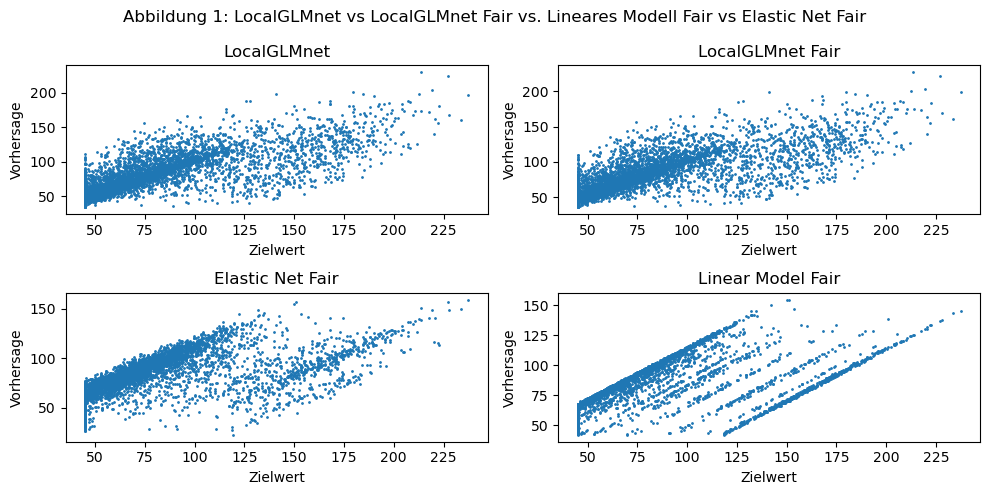

MSE LocalGLMnet Fair: 598.488068925507
MSE Elastic Net Fair: 927.9727881223604
MSE lineares Modell Fair: 1002.5659511690311


In [45]:
# Plotten der Vorhersage gegen Zielwerte
fig_performance = plt.figure(tight_layout=True, figsize=(10, 5))

spec = GridSpec(ncols=2, nrows=2, figure=fig_performance)
axs_perf = [
    fig_performance.add_subplot(spec[0, 0:1]),
    fig_performance.add_subplot(spec[0, 1:2]),
    fig_performance.add_subplot(spec[1, 0:1]),
    fig_performance.add_subplot(spec[1, 1:2]),
]

# Plotten sowohl für LocalGLMnet, LocalGLMnet fair, Lineares Modell fair und Elastic Net fair
axs_perf[0].scatter(y_test, y_pred_local, s=1)
axs_perf[0].set_title("LocalGLMnet")
axs_perf[1].scatter(y_test, y_pred_local_fair, s=1)
axs_perf[1].set_title("LocalGLMnet Fair")
axs_perf[2].scatter(y_test, adjusted_enet_premium, s= 1)
axs_perf[2].set_title("Elastic Net Fair")
axs_perf[3].scatter(y_test, y_pred_linear_wo_indir_discr, s= 1)
axs_perf[3].set_title("Linear Model Fair")

# Setzen der Ploteigenschaften
for ax in axs_perf:
    ax.set_xlabel("Zielwert")
    ax.set_ylabel("Vorhersage")

# Titel des Plots
fig_performance.suptitle("Abbildung 1: LocalGLMnet vs LocalGLMnet Fair vs. Lineares Modell Fair vs Elastic Net Fair")

# Plotten
plt.show()

# Ausgabe der Mean Squared Errors
print(f'MSE LocalGLMnet Fair: {mse_local_fair}')
print(f'MSE Elastic Net Fair: {mse_enet_fair}')
print(f'MSE lineares Modell Fair: {mse_linear_fair}')

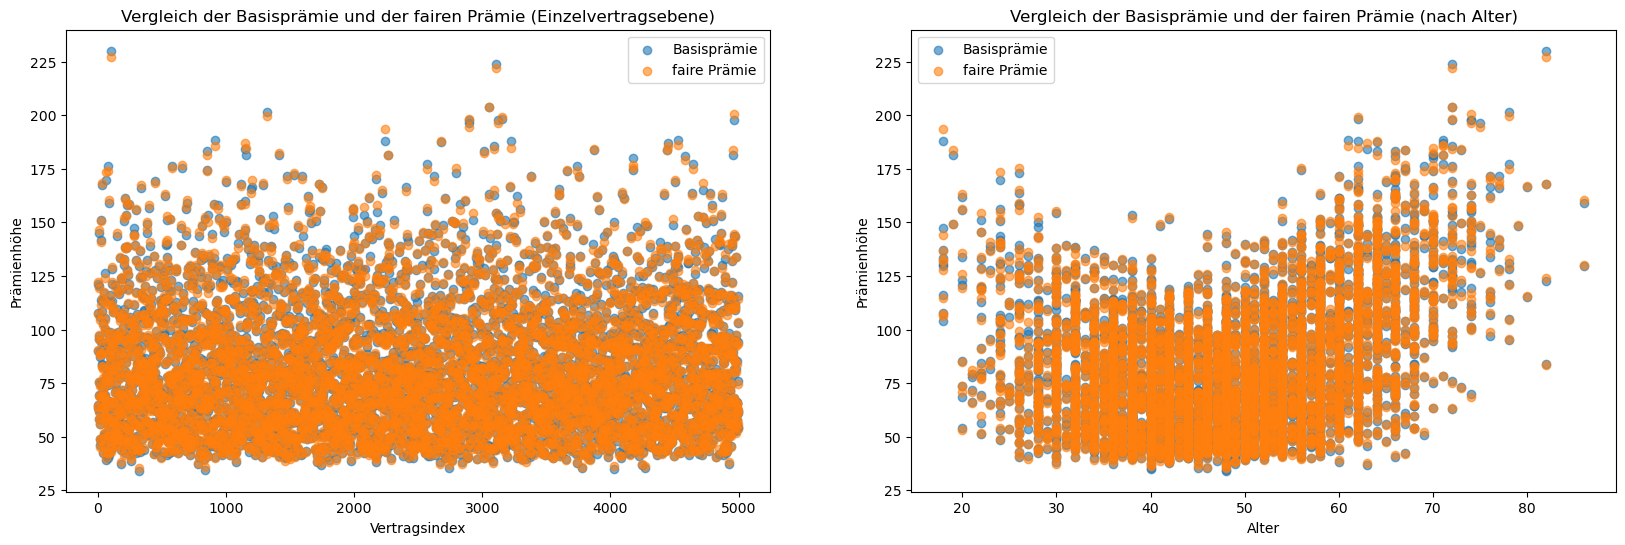

Durchschnittliche Basisprämie: 82.00066375732422
Durchschnittliche faire Prämie: 81.8348159790039


In [46]:
# Vergleich zwischen LocalGLMnet ohne direkte Diskriminierung (Basisprämie) und LocalGLMnet ohne indirekte Diskriminierung (Faire Prämie)
comparison_base_fair(y_pred_local.flatten(), y_pred_local_fair.flatten(), age_test)

<ins>Kommentar</ins>: Die faire Prämie sieht fast exakt wie die Basisprämie aus. Es gibt an manchen Stellen sehr leichte Verschiebungen, aber die Datenpunkte überlagern sich doch sehr. Im Vergleich zu den anderen Modellen, lässt sich hier kein An-/Abstieg über den Altersverlauf erkennen. Dies lässt vermuten, dass die indirekte Diskriminierung durch das Merkmal Alter nicht sonderlich erkannt wurde oder nicht vorhanden ist.
Die durchschnittliche faire Prämie ist ganz leicht geringer als die durchschnittliche Basisprämie.

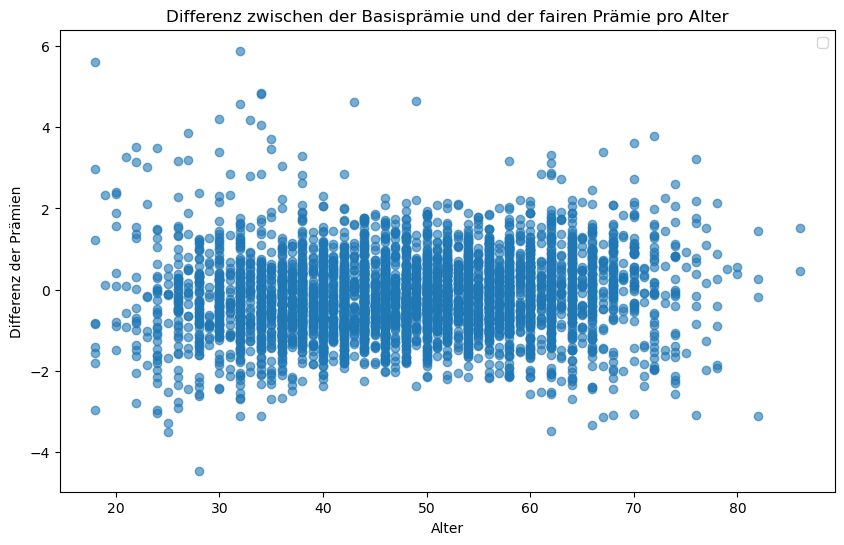

In [47]:
# Plotten der Differenzen pro Alter
scatterplot_differences(y_pred_local.flatten(), y_pred_local_fair.flatten(), age_test)

<ins>Kommentar</ins>: Hier kann man auch sehr gut erkennen, dass die Differenzen keinen Unterschied zwischen den Altern machen. Auch hier lässt sich gut sehen, dass die indirekte Diskriminierung durch Alter nicht erkannt wurde oder nicht vorhanden ist.

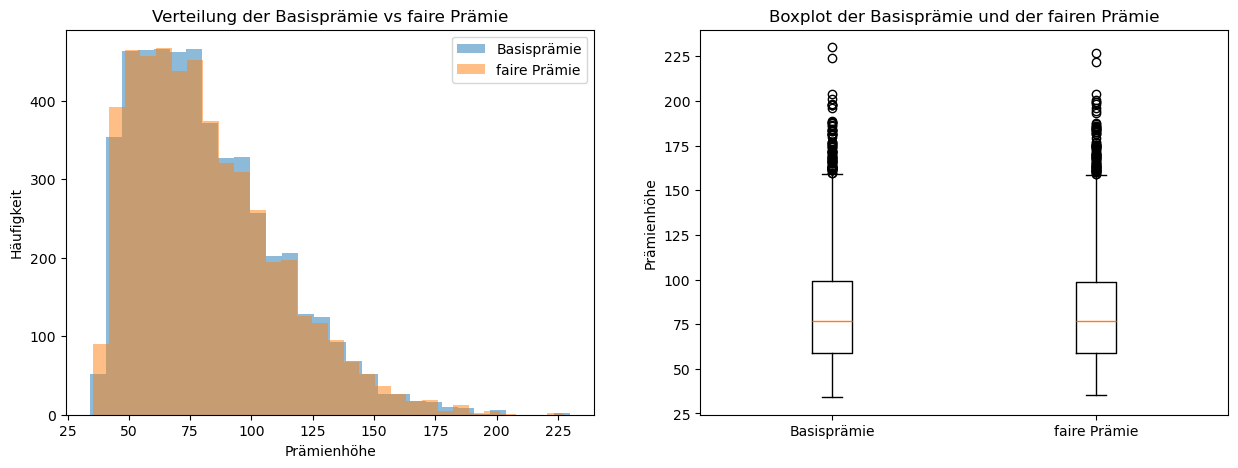

In [48]:
# Plotten der Basis- vs. fairen Prämie auf aggregierter Ebene
aggregated_plots(y_pred_local.flatten(), y_pred_local_fair.flatten())

<ins>Kommentar</ins>: Die beiden Plots bestärken noch einmal den Eindruck von vorher. Die faire Prämie ist so geringfügig angepasst, dass sie fast an allen Stellen und auch bei den Ausreißern noch der Basisprämie entspricht.

#### Erklärbarkeitsansätze

In [49]:
#Feature Importances des linearen Modells, ohne Intercept
linear_model_feature_importance = np.abs(linear_model_wo_indir_discr.params[1:]) 
print(f'Feature Importances des fairen linearen Modells: \n{linear_model_feature_importance}')

#Feature Importances des Elastic Nets
enet_feature_importance = np.abs(main_enet.coef_)
feature_names = list(dfdata_raw.drop(columns=['Response', 'freq', 'Gender', 'Age']).columns)
feature_importance = pd.DataFrame({'Feature': feature_names,'Importance': enet_feature_importance})
print(f'\nFeature Importances des fairen Elastic Nets: \n{feature_importance}')

Feature Importances des fairen linearen Modells: 
SquareM            19.815141
HouseholdIncome     0.370065
InventoryValue      0.034768
CityType            0.079024
dtype: float64

Feature Importances des fairen Elastic Nets: 
           Feature  Importance
0          SquareM   19.361887
1  HouseholdIncome    0.263014
2   InventoryValue    8.131531
3         CityType    0.487397


<ins>Kommentar</ins>: Die Feature Importance gibt an, welche Merkmale bei der Modellvorhersage am einflussreichsten sind.  
Bei einem linearen Modell entsprechen diese Feature Importances den Koeffizienten. Hier ist es vor allem das Merkmal Wohnfläche was stark ins Gewicht fällt.  
In einem Elastic Net geben die Merkmalsgewichte an, wie viel ein bestimmtes Merkmal zur Vorhersage beiträgt. Auch bei dem fairen Elastic Net hat das Merkmal Wohnfläche das größte Gewicht. Hierbei ist allerdings auch das Gewicht für Inventarwert deutlich höher als bei dem fairen linearen Modell.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
44/44 ━━━━━━━━━━━━━

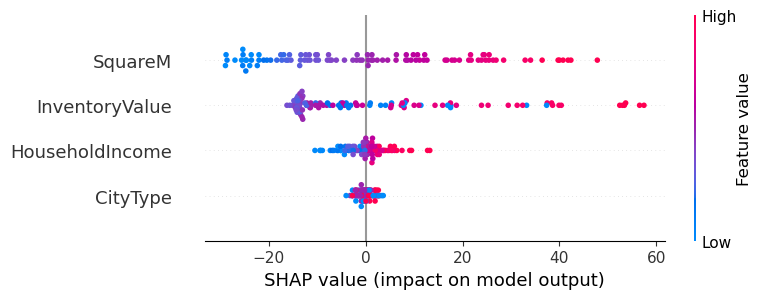

In [50]:
# Shapley Values des fairen LocalGLMnets
# Erstellen eines Shapley Objektes
explainer_local_fair = shap.KernelExplainer(local_glm_net.predict, kmeans_samples_train, feature_names=feature_names)

# Berechnen der Shapley Werte
shap_values_local_fair = explainer_local_fair.shap_values(kmeans_samples_test.data)

# Plotten der Shapley Values
shap.summary_plot(np.squeeze(shap_values_local_fair), kmeans_samples_test.data, feature_names=feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

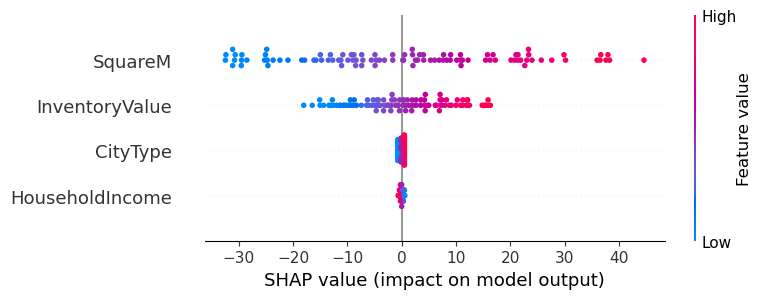

In [51]:
# Shapley Values des fairen Elastic Nets
# Erstellen eines Shapley Objektes
explainer_EN_fair = shap.KernelExplainer(main_enet.predict, kmeans_samples_train, feature_names=feature_names)

# Berechnen der Shapley Werte
shap_values_EN_fair = explainer_EN_fair.shap_values(kmeans_samples_test.data)

# Plotten der Shapley Values
shap.summary_plot(np.squeeze(shap_values_EN_fair), kmeans_samples_test.data, feature_names=feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

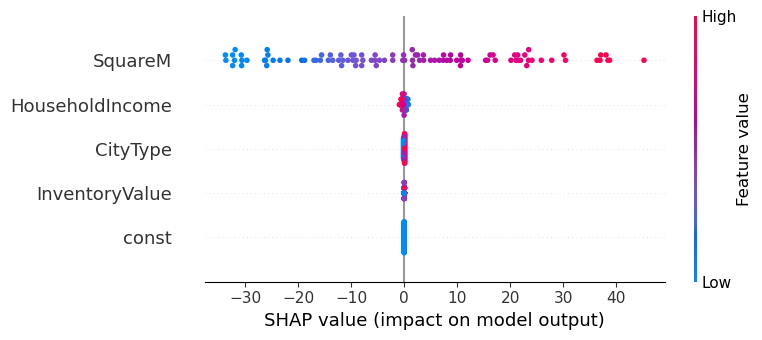

In [52]:
# Shapley Values des fairen linearen Modells
# Erstellen eines Shapley Objektes
explainer_linear_fair = shap.KernelExplainer(linear_model_wo_indir_discr.predict, kmeans_samples_train_const, feature_names=['const']+feature_names)

# Berechnen der Shapley Werte
shap_values_linear_fair = explainer_linear_fair.shap_values(kmeans_samples_test_const)

# Plotten der Shapley Values
shap.summary_plot(np.squeeze(shap_values_linear_fair), kmeans_samples_test_const, feature_names=['const']+feature_names)

<ins>Kommentar</ins>: Vergleich der Shapley Values der 3 fairen Modelle  
Bei allen 3 Modellen bilden Wohnfläche und dann Inventarwert die höchste Wichtigkeit. Bei dem localGLMnet und dem Elastic Net folgen dann Haushaltseinkommen und City Type, beim linearen Modell ist die Reihenfolge der letzten beiden Merkmale getauscht (und zusätzliche Konstante).  
Beim linearen Modell und bei dem Elastic Net sind die Wirkungsrichtungen recht gleich verteilt. Links von der Nulllinie befinden sich eher bläuliche Farbtöne, rechts davon eher rötliche. Es gibt eine Ausnahme beim Elastic Net, und zwar sind die Wirkungsrichtungen bei dem Merkmal Haushaltseinkommen einmal genau vertauscht. Bei dem LocalGLMnet sind die Farben bei Inventarwert und CityType recht durchgemischt, bei den anderen beiden Merkmalen auch eher sortiert.  
Bei dem Elastic Net sind diese Werte recht gleichverteilt auf den beiden Seiten der Nulllinie. Beim linearen Modell finden sich, bis auf beim Merkmal Wohnfläche, die Datenpunkte alle um die Nulllinie wieder. Das Merkmal Inventarwert beim LocalGLMnet clustert sich zum Teil auf der linken Seite.  

#### Business Case

Betrachten Sie abschließend, wie der Tarif unter den hypothetischen Rahmenbedingungen, dass keinerlei Korrelation mit geschützten Merkmalen im Tarif vorhanden sein darf, aussehen könnte und welche Herausforderungen sich im Vergleich ergeben. Betrachten Sie insbesondere Langzeitfolgen von Moral Hazard und Adverser Selektion in einem kompetitiven Marktumfeld. Beschreiben Sie einen vergleichenden Business Case, der strategische und formale Empfehlungen abgibt.

<strong><ins>Business Case Vermeidung indirekter Diskriminierung in der Hausratversicherung</ins>: </strong> 

<strong>Ausgangslage:</strong> 
Ein innovatives Produkt in der Hausratversicherung soll eingesetzt werden. Bei diesem Produkt sollen, im Gegensatz zu Standard-Tarifen, u.a. Merkmale zum Einsatz kommen, die im weiteren Sinne als soziodemographisch betrachtet werden können. Angesichts des Artificial Intelligence Act (AI-Act) und der Datenschutz-Grundverordnung (DSGVO) ist es notwendig, die Fairness und Transparenz dieses Produktes und der entsprechenden Modelle zu gewährleisten und direkte sowie indirekte Diskriminierung zu vermeiden.

<strong>Zielsetzung:</strong>  
Für das innovative Hausratprodukt sollen Modelle entwickelt werden, die direkte und indirekte Diskriminierung (insbesondere des Merkmals Alter) vermeiden und den Anforderungen an die gesetzlichen Vorgaben, unter anderem zum Datenschutz, entsprechen. Dies soll durch die Anwendung verschiedener Fairness-Methoden erreicht werden, ohne die Modellleistung signifikant zu beeinträchtigen.  

<strong>Mögliche Fairness-Methoden:</strong> 
- <strong>Correlation Remover:</strong> Entfernen von Korrelationen zwischen den erklärenden Variablen und den sensiblen Merkmalen, insbesondere dem Alter. Dieses Modell führt zu einem leichten Anstieg des Mean Squared Error (MSE) im Vergleich zum Modell ohne indirekte Diskriminierung. Dafür bilden sich stabilere Prämien, die nicht mehr abhängig vom Alter sind und somit die indirekte Diskriminierung mindert.  
- <strong>Adversarielles Modell:</strong> Ein adversarielles Modell erschwert die Vorhersage des Alters, um indirekte Diskriminierung zu reduzieren. Durch Trainieren eines Nebenmodells mit Zielvariable Alter, lässt sich die indirekte Diskriminierung aus dem Hauptmodell verringern. Das adversarielle Modell hat eine niedrige Genauigkeit, was darauf hindeutet, dass sich mit den restlichen erklärenden Variablen nicht gut das Alter voraussagen lässt. Dies weist auf geringe indirekte Diskriminierung hin. Es gibt einen leichten Anstieg des MSE, aber dafür eine verbesserte Fairness der Prämie.  
- <strong>Custom Loss Function im LocalGLMnet:</strong> Die Loss-Funktion wird individualisiert und um eine Fairness-Strafe erweitert. Diese soll die Korrelation zwischen Alter und Vorhersage verringern. Es gibt kaum Unterschiede zwischen fairen Prämien und Basisprämien, was auf eine geringe indirekte Diskriminierung hinweist. Der MSE sinkt ganz leicht.

<strong>Herausforderungen</strong>
- Datenqualität und -verfügbarkeit: Die Daten können mit einem Bias belegt sein. Daten können Verzerrungen enthalten, die zu unfairen Modellen führen. Es ist wichtig, diese Verzerrungen zu erkennen und zu korrigieren. Zudem kann es zu fehlenden Daten kommen. Sensible Merkmale werden zum Teil nicht erfasst, was die Bewertung und Korrektur von Diskriminierung erschwert.
- Technische Herausforderungen: Um indirekte Diskriminierung zu entfernen muss diese zuerst erkannt und den Ersatzmerkmalen zugeordnet werden. Die Implementierung von Fairness-Methoden erfordert technisches Wissen und kann die Modellkomplexität erhöhen, IT-Voraussetzungen erschweren und Wartungsarbeiten verkomplizieren.
- Schulung der Mitarbeiter: Die Mitarbeiter müssen in den Modellen geschult werden, um die Fairness der Modelle bei der Nutzung zu wahren und auch die Erklärbarkeit und Transparenz sicher zu stellen.  

<strong>Langzeitfolgen</strong>
- <strong>Moral Hazard</strong>: Versicherte ändern ihr Verhalten, weil sie wissen, dass sie versichert sind und verhalten sich somit risikoreicher. Dies kann zu erhöhten Kosten auf Seiten des Versicherers führen. Man kann Moral Hazard entgegenwirken, indem es gewisse Verhaltensanreize für die Versicherten gibt und eine regelmäßige Überprüfung der Risikobewertung stattfindet.  

- <strong>Adverse Selektion</strong>: Versicherte, die ein höheres Risiko besitzen, schließen eher eine Versicherung ab, als Personen, die grundsätzlich ein geringes Risiko haben. Dies führt zu einer Ungleichverteilung innerhalb des Versichertenkollektivs und dementsprechend zu höheren Prämien. Um adverse Selektion zu meiden sollte man Modelle entwickeln, die eine faire Risikobewertung zugrunde legen und die Attraktivität für risikoarme Versicherte erhöhen.  

<strong>Strategische Empfehlungen:</strong>
- Implementierung von Erklärbarkeitsansätzen und Fairness-Beschränkungen, um Diskriminierung zu vermeiden
- Sicherstellen, dass die Tarifgestaltung fair und nachvollziehbar (auch für Kunden) ist
- Regelmäßige Überprüfung der Risikobewertung, um sicherzustellen, dass die Modelle fair und transparent bleiben und keine neue indirekte Diskriminierung aufweisen  

<strong>Formale Empfehlungen</strong>
- Routinierte Überprüfungen: Durchführung regelmäßiger Prüfungen der Modelle, um sicherzustellen, dass sie fair und transparent sind
- Regulatorische Compliance: Die Modelle müssen zu jedem Zeitpunkt den gesetzlichen Vorschriften, wie zum Beispiel der DSGVO, dem AI Act oder der Unisex Tarifierung, entsprechen. Dies erfordert eine kontinuierliche Überwachung und Anpassung der Modelle. Zudem wird hier verlangt, dass die Modelle transparent und erklärbar sind, auch dies muss für komplexe Modelle einhaltbar sein.  

<strong>Fazit:</strong>
Die Implementierung fairer und transparenter Modelle ist entscheidend, um Diskriminierung (direkt und indirekt) zu vermeiden und das Vertrauen der Kunden zu gewinnen. Durch den Einsatz von Erklärbarkeitsansätzen und Fairness-Beschränkungen können Versicherer sicherstellen, dass ihre Tarifgestaltung rechtens, fair und nachvollziehbar ist. Langfristig können diese Maßnahmen dazu beitragen, Moral Hazard und adverse Selektion zu minimieren und eine nachhaltige Geschäftsstrategie zu entwickeln.

### Aufgabe 6: [Management Summary] [15 Punkte]
Fassen Sie Ihre Erkenntnisse in einem Bericht von maximal zwei DinA4-Seiten zusammen, wovon 1/2 Seite Management Summary sein soll. Dies kann am Ende des abgegebenen Notebooks oder als separates PDF erfolgen.

<ins><strong>Management Summary und Bericht</ins>: </strong>  

Dieser Bericht analysiert ein innovatives Produkt in der Hausratversicherung. Bei diesem Produkt sollen, im Gegensatz zu Standard-Tarifen, u.a. Merkmale zum Einsatz kommen, die im weiteren Sinne als soziodemographisch betrachtet werden können. Ebenso werden die Auswirkungen des Artificial Intelligence Act (AI-Act) und der Datenschutz-Grundverordnung (DSGVO) in diesem Bericht untersucht. Die Analyse umfasst Datenuntersuchungen, Modelle und Bewertugen von Diskriminierungsrisiken. Hierfür sind verschiedene Modelle modelliert und getestet worden, um direkte und indirekte Diskriminierung zu vermeiden. Dabei spielen vor allem Fairness und Transparenz eine tragende Rolle. Die Ergebnisse zeigen, dass durch die Entfernung diskriminierender Merkmale und die Anwendung von Fairness-Methoden die Modellleistung nur minimal beeinträchtigt wird, während die Fairness deutlich verbessert wird. 

<ins><strong>Summary</ins>: </strong>  
<ins>Datenanalyse:</ins> Der Datensatz enthält 25.000 Zeilen mit 8 Merkmalen. Hohe Korrelation zwischen Frequenz und Response, was auf einen Ausschluss hindeutet, um Abhängigkeiten zu vermeiden. Merkmale wie Alter und Inventarwert korrelieren stark. Die Analyse identifiziert potenzielle Problemfelder, unter Anderem die Nutzung des Geschlechts als Merkmal, da dies gesetzlich nicht mehr zulässig ist.

<ins>Tarifmodell:</ins> Es werden 3 mögliche Modelle vorgeschlagen: lineares Modell, Elastic Net und LocalGLMnet. Bei allen Modellen sind die Merkmale Geschlecht und Alter entfernt um direkte Diskriminierung direkt zu meiden. Das LocalGLMnet hat hier den besten Mean Squared Error.

<ins>Indirekte Diskriminierung:</ins> Identifizierung von Ersatzmerkmale, die indirekt diskriminieren könnten. Hier wurde für das Alter das Proxy-Merkmal Inventarwert identifiziert.

<ins>Vermeidung indirekter Diskriminierung:</ins> Die obigen 3 Tarifmodelle wurden durch Anpassungen zu fairen Modellen. Zur Bewertung dieser fairen Modelle wurden Shapley-Werte und Attention-Methoden herbeigezogen. Es wurden die Methoden Correlation Remover, adversarielles Modell und Custom Loss-Funktion genutzt. Die Modelle werden anschließend auf indirekte Diskriminierung getestet. 
Die beiden ersten Modelle zeigen, dass die faire Prämie weniger stark durch das Alter beeinflusst wird. Das LocalGLMnet Modell mit einer angepassten Loss-Funktion zeigt jedoch keine signifikante Verbesserung.

<ins>Regulatorische Aspekte:</ins> Der AI Act und die DSGVO stellen hohe Anforderungen an die Fairness und Transparenz von KI-Modellen. Die untersuchten Modelle müssen regelmäßig auditiert und angepasst werden, um diesen Anforderungen gerecht zu werden. Schulungen und regulatorische Compliance sind essenziell.

<ins>Fazit:</ins> Die Analyse zeigt die Bedeutung fairer und transparenter Modellierung in der Versicherung. Durch die Entfernung direkter und indirekter Diskriminierung werden die regulatorischen Vorschriften eingehalten und die Fairness der Modelle verbessert, ohne die Leistung wesentlich zu beeinträchtigen. Langfristig tragen die Maßnahmen dazu bei, Moral Hazard und Adverse Selektion zu minimieren und eine nachhaltige Geschäftsstrategie zu entwickeln.

<ins><strong>Weitere Details</ins>: </strong>  
<ins>Identifizierte Problemfelder:</ins> Ein identifziertes schwerwiegendes Problemfeld ist das Merkmal Geschlecht. Dieses darf seit 2012 nicht mehr für die Tarifierung verwendet werden, da es als diskriminierend betrachtet wird. Aus gesetzlichen Gründen muss dieses Merkmal also aus den Modellen entfernt werden. Ein weiteres Problemfeld könnte das Alter sein. Durch fortschreitende Entwicklungen im Leben und höheren Einkommen im Verlauf, könnte das Alter einen großen Einfluss auf das Haushaltseinkommen und den Inventarwert haben. Die Frequenz ist ein Merkmal, welches auch zu Problemen führen kann. Da Response und Frequenz sehr stark voneinander abhängig sind und Frequenz schon fast die Zielvariable vorhersagen kann, ist es notwendig dieses auszuschließen. Das Merkmal Stadttyp könnte einen großen Einfluss auf bspw. das Haushaltseinkommen und den Lebensstandard haben.

<ins>Details zu den einzelnen fairen Modellen:</ins>
- Correlation Remover: Entfernen von Korrelationen zwischen den erklärenden Variablen und den sensiblen Merkmalen, insbesondere dem Alter. Dieses Modell führt zu einem leichten Anstieg des Mean Squared Error (MSE) im Vergleich zum Modell ohne indirekte Diskriminierung. Die durchschnittliche faire Prämie war leicht höher als die durchschnittliche Basisprämie, da jüngere Altersgruppen einen Aufschlag erhielten. Die Differenzen der Prämien pro Alter zeigten, dass die Aufschläge mit dem Alter abnahmen und ab einem bestimmten Alter zu Abschlägen wurden, was die indirekte Diskriminierung durch Alter minderte und zu stabileren Prämien führte.

- Adversarielles Modell. Ein adversarielles Modell erschwert die Vorhersage des Alters, um indirekte Diskriminierung zu reduzieren. Durch Trainieren eines Nebenmodells mit Zielvariable Alter, lässt sich die indirekte Diskriminierung aus dem Hauptmodell verringern. Das adversarielle Modell hat eine niedrige Genauigkeit, was darauf hindeutet, dass sich mit den restlichen erklärenden Variablen nicht gut das Alter voraussagen lässt. Dies weist auf geringe indirekte Diskriminierung hin. Es gibt einen leichten Anstieg des MSE, aber dafür eine verbesserte Fairness der Prämie. Die fairen Prämien waren stabiler über das Alter hinweg und zeigten weniger starke Schwankungen im Vergleich zu den Basisprämien.

- Custom Loss Function im LocalGLMnet: Die Loss-Funktion wird individualisiert und um eine Fairness-Strafe erweitert. Diese soll die Korrelation zwischen Alter und Vorhersage verringern. Es gibt kaum Unterschiede zwischen fairen Prämien und Basisprämien, was darauf hindeutet, dass die indirekte Diskriminierung durch Alter nicht signifikant erkannt wurde. Die Shapley-Werte und Attention-Methoden bestätigten, dass die Merkmale Wohnfläche und Inventarwert die wichtigsten Einflussfaktoren blieben. Der MSE sinkt ganz leicht.  

<ins><strong>Gesamtfazit</ins>: </strong>  
Die vorliegende Analyse eines innovativen Hausratversicherungsprodukts zeigt, dass durch den gezielten Einsatz von Fairness-Methoden und die Entfernung diskriminierender Merkmale sowohl direkte als auch indirekte Diskriminierung effektiv reduziert werden können. Die Untersuchung hat verdeutlicht, dass die Modellleistung durch diese Maßnahmen nur minimal beeinträchtigt wird, während die Fairness der Prämienberechnung signifikant verbessert wird. Insbesondere die Methoden zur Entfernung von Korrelationen und die adversariellen Modelle waren effektiv darin, die indirekte Diskriminierung zu mindern. Die individualisierte Verlustfunktion im LocalGLMnet zeigte jedoch, dass die Erkennung und Beseitigung indirekter Diskriminierung durch Alter eine Herausforderung bleibt.

Die Einhaltung der regulatorischen Anforderungen des AI Act und der DSGVO ist essenziell für die nachhaltige Entwicklung und den Erfolg von KI-basierten Versicherungsprodukten. Die Ergebnisse dieser Analyse unterstreichen die Bedeutung einer ethischen und verantwortungsvollen Modellierung in der Versicherungsbranche und bieten wertvolle Einblicke für zukünftige Entwicklungen.
